In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
%reload_ext lab_black

In [40]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_context("talk")

In [3]:
from src.load_data import load_data

epoch_key = ("cha", 1, 3)

data = load_data(epoch_key)

Failed to load file: /home/zilong/Desktop/replay_trajectory_paper/Raw-Data/Chapati/chaDIO01.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /home/zilong/Desktop/replay_trajectory_paper/Raw-Data/Chapati/chaDIO01.mat
No DIO file found, inferring correct inbound/outbound from task rules
Failed to load file: /home/zilong/Desktop/replay_trajectory_paper/Raw-Data/Chapati/chaDIO01.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /home/zilong/Desktop/replay_trajectory_paper/Raw-Data/Chapati/chaDIO01.mat
No DIO file found, inferring correct inbound/outbound from task rules


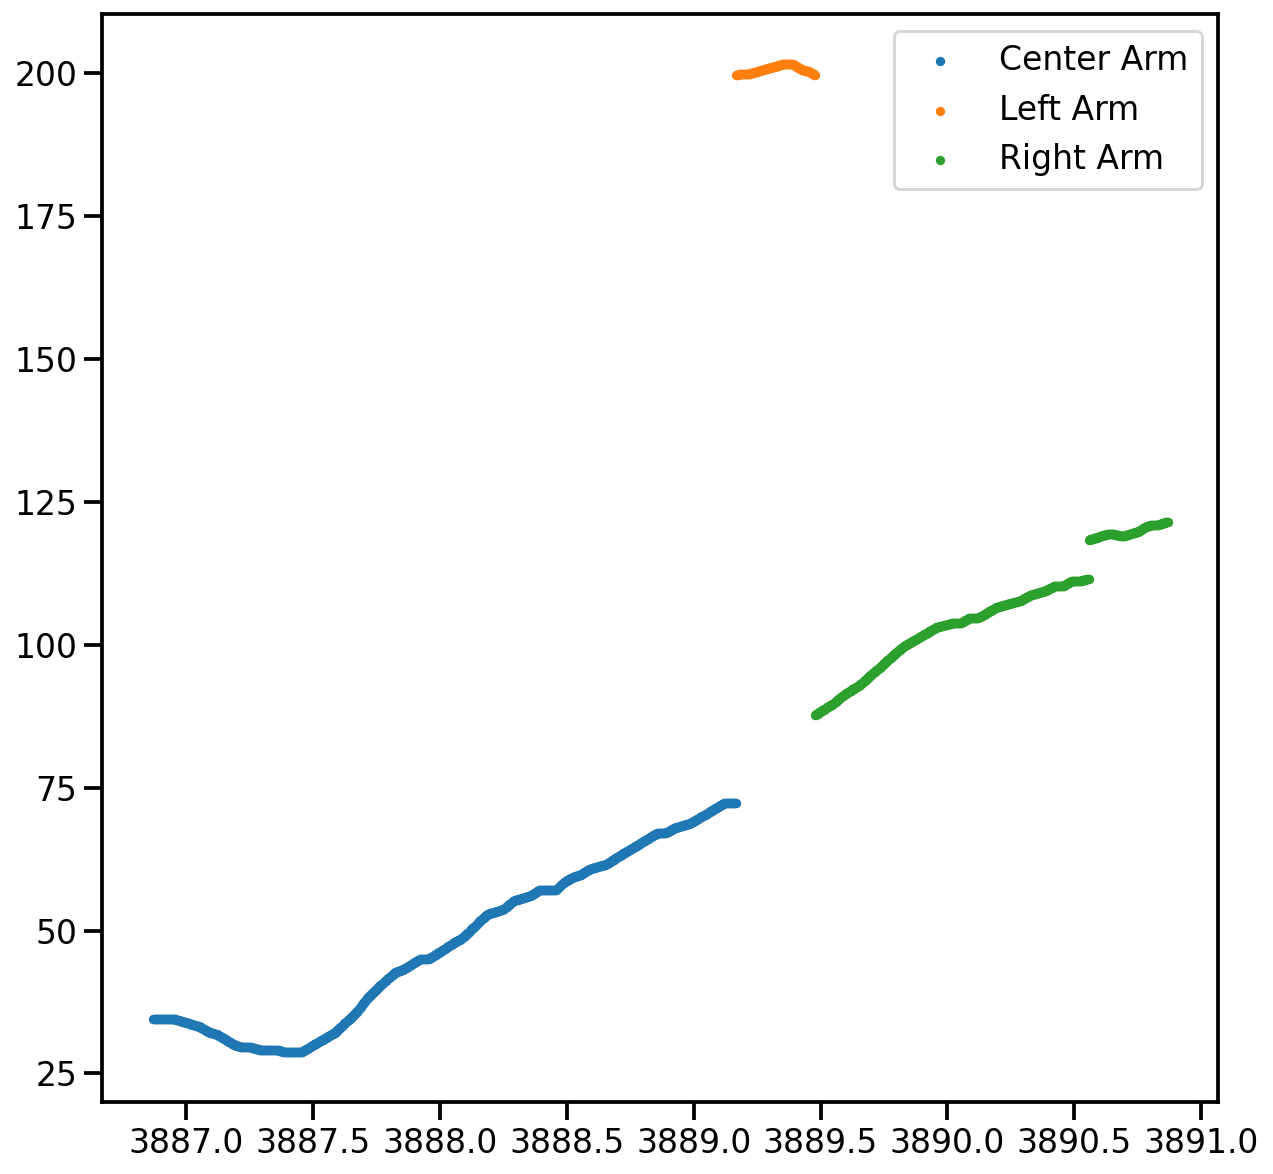

In [4]:
t = data["position_info"].index / np.timedelta64(1, "s")
time_slice = slice(t.min() + 240.85, t.min() + 244.85)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

for task, df in (
    data["position_info"].reset_index().set_index(t).loc[time_slice].groupby("arm_name")
):
    ax.scatter(
        df.index,
        df.linear_position,
        s=10,
        label=task,
    )

plt.legend()

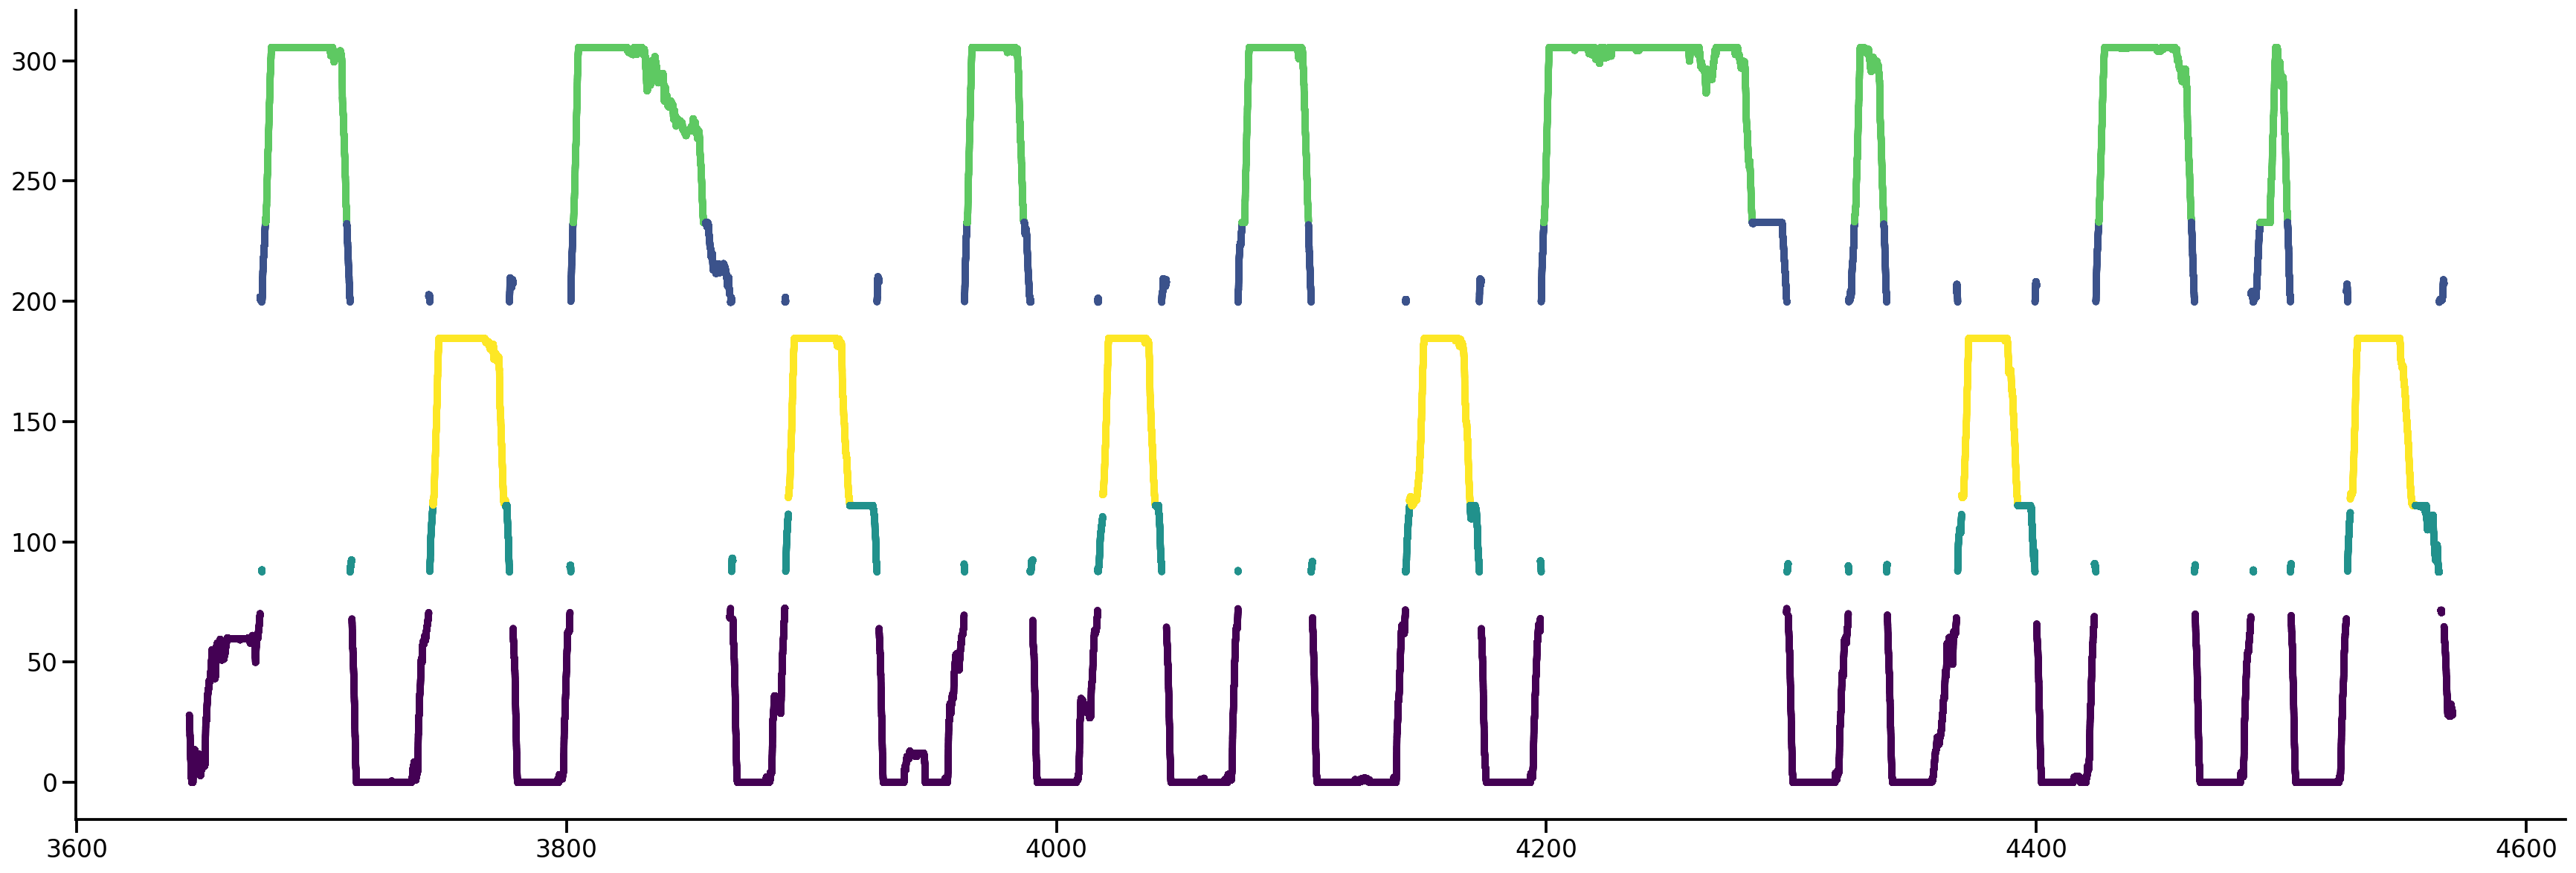

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(30, 10))

ax.scatter(
    data["position_info"].index / np.timedelta64(1, "s"),
    data["position_info"].linear_position,
    c=data["position_info"].track_segment_id,
    s=10,
)
sns.despine()

In [8]:
from loren_frank_data_processing.position import (
    make_track_graph,
    EDGE_ORDER,
    EDGE_SPACING,
)
from src.parameters import ANIMALS

is_running = data["position_info"].speed > 4
is_outbound = data["position_info"].task == "Outbound"

track_labels = data["position_info"].arm_name

track_graph, center_well_id = make_track_graph(epoch_key, ANIMALS)

Inbound
Outbound


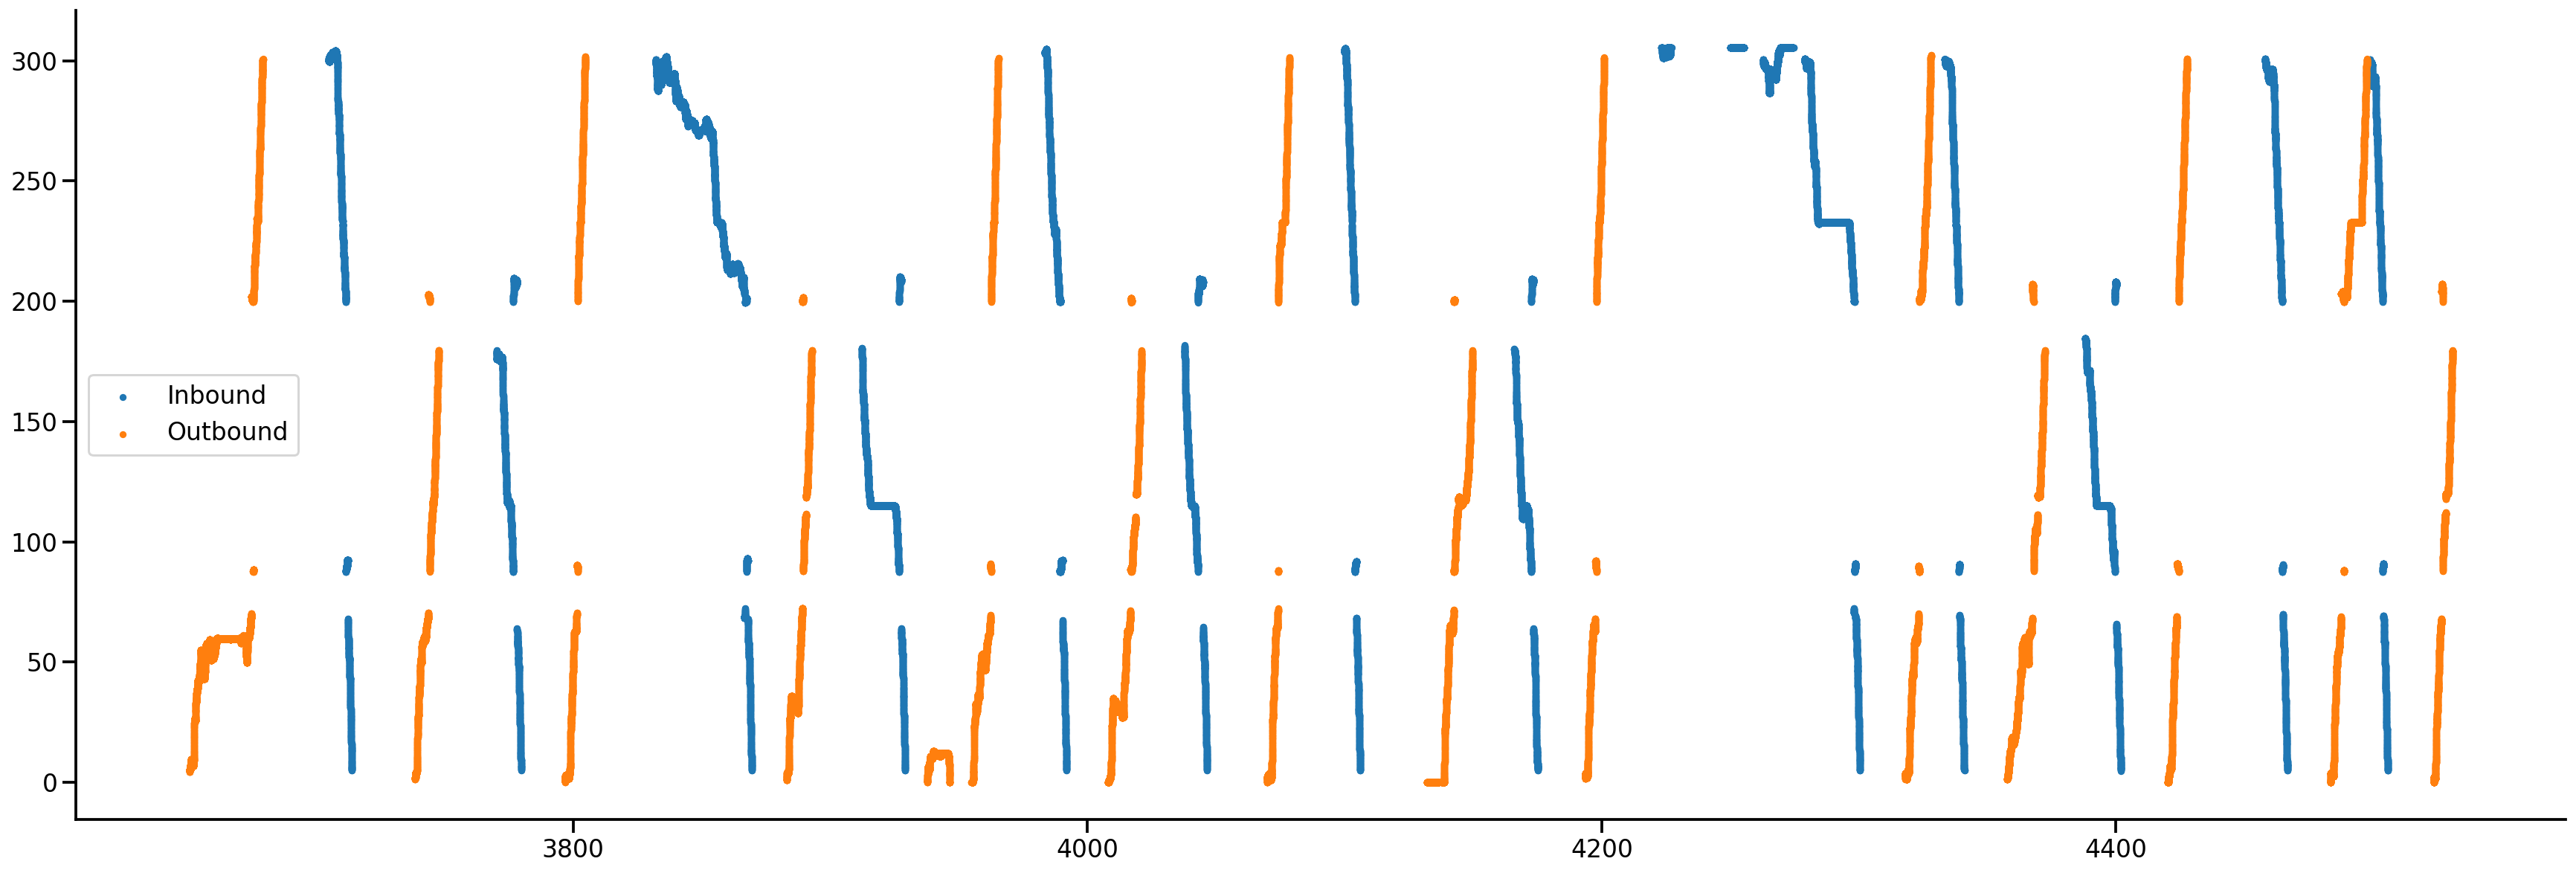

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(30, 10))

for task, df in data["position_info"].groupby("task"):
    print(task)
    ax.scatter(
        df.index / np.timedelta64(1, "s"),
        df.linear_position,
        s=10,
        label=task,
    )

plt.legend()
sns.despine()

Center Arm
Left Arm
Right Arm


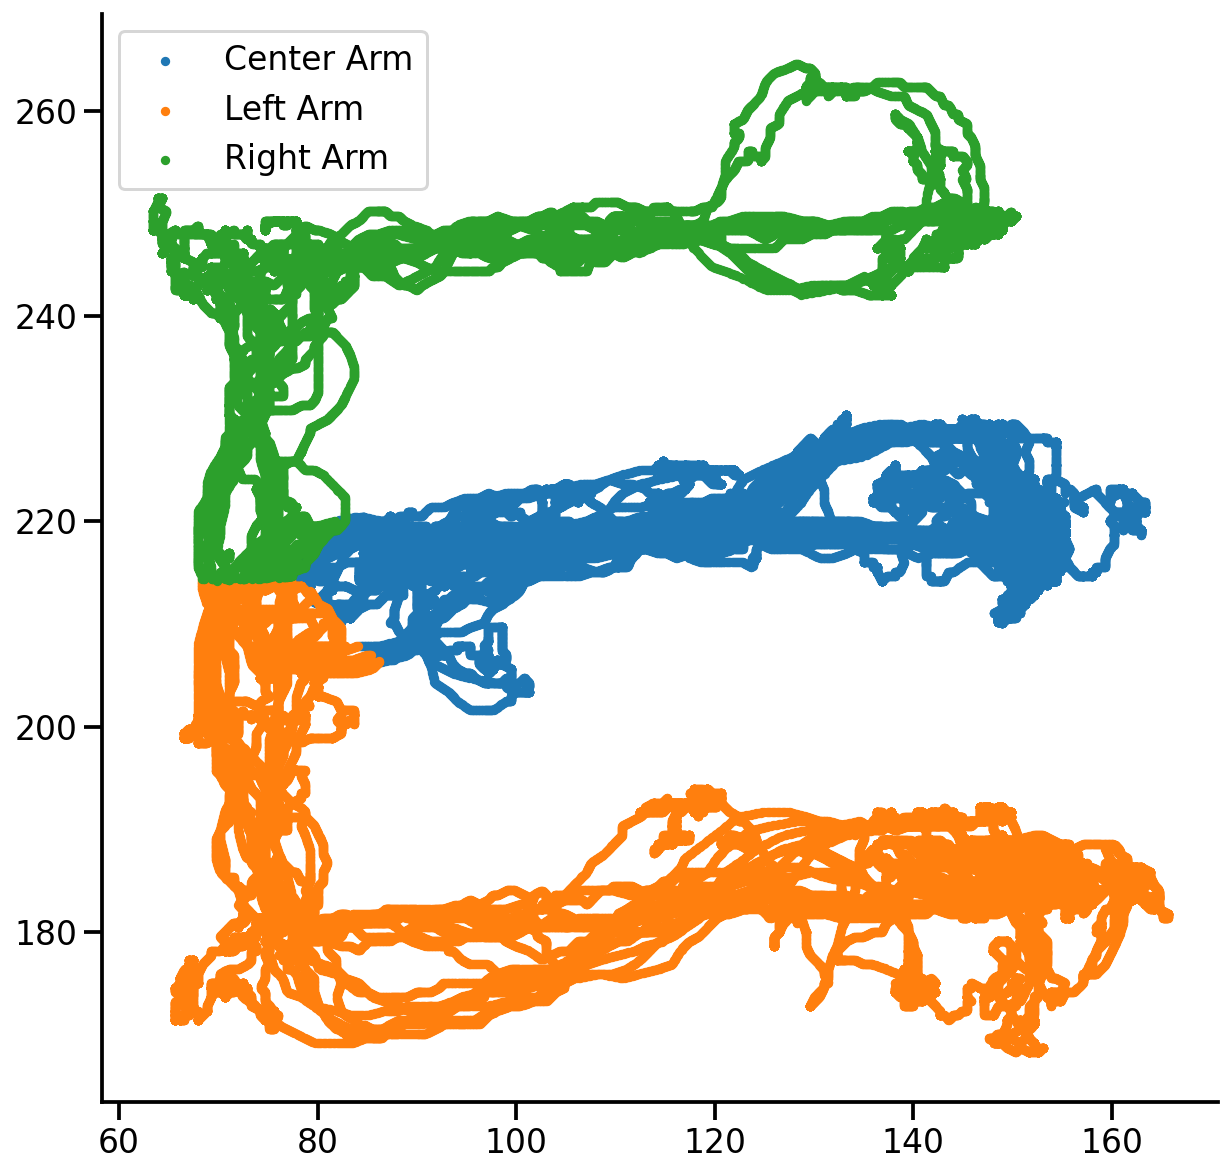

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

for task, df in data["position_info"].groupby("arm_name"):
    print(task)
    ax.scatter(
        df.y_position,
        df.x_position,
        s=10,
        label=task,
    )

plt.legend()
sns.despine()

In [21]:
from replay_trajectory_classification import ClusterlessClassifier
from src.parameters import classifier_parameters, discrete_state_transition

from sklearn.model_selection import KFold
from tqdm.auto import tqdm

In [23]:
classifier = ClusterlessClassifier(**classifier_parameters)

cv = KFold()
cv_classifier_clusterless_results = []

for fold_ind, (train, test) in tqdm(enumerate(cv.split(data["position_info"].index))):

    cv_classifier = ClusterlessClassifier(**classifier_parameters)

    cv_classifier.fit(
        position=data["position_info"].iloc[train].linear_position,
        multiunits=data["multiunit"].isel(time=train),
        is_training=is_running.iloc[train],
        track_graph=track_graph,
        center_well_id=center_well_id,
        edge_order=EDGE_ORDER,
        edge_spacing=EDGE_SPACING,
    )
    cv_classifier.discrete_state_transition_ = discrete_state_transition

    cv_classifier_clusterless_results.append(
        cv_classifier.predict(
            data["multiunit"].isel(time=test),
            time=data["position_info"].iloc[test].index / np.timedelta64(1, "s"),
        )
    )

5it [37:37, 451.55s/it]


In [56]:
import xarray as xr

cv_classifier_clusterless_results = xr.concat(
    cv_classifier_clusterless_results, dim="time"
)


TypeError: can only concatenate xarray Dataset and DataArray objects, got <class 'str'>

In [57]:
cv_classifier_clusterless_results.to_netcdf(
    f"{epoch_key[0]}_{epoch_key[1]:02d}_{epoch_key[2]:02d}_cv_classifier_clusterless_results.nc"
)

: 

In [26]:
def plot_local_non_local_time_slice_classifier(
    time_slice,
    classifier,
    results,
    data,
    posterior_type="acausal_posterior",
    figsize=(30, 15),
):
    cmap = plt.cm.viridis
    cmap.set_bad("white", alpha=0.0)

    fig, axes = plt.subplots(
        4,
        1,
        figsize=figsize,
        sharex=True,
        constrained_layout=True,
        gridspec_kw={"height_ratios": [3, 1, 1, 1]},
    )

    # ax 0
    results[posterior_type].sum("state", skipna=False).sel(time=time_slice).plot(
        x="time",
        y="position",
        robust=True,
        ax=axes[0],
        cmap=cmap,
        vmin=0.0,
    )

    arm_min_max = (
        data["position_info"]
        .groupby("arm_name")
        .linear_position.aggregate(["min", "max"])
    )
    max_time = results.sel(time=time_slice).time.max() + 0.01
    axes[0].text(
        max_time,
        arm_min_max.loc["Center Arm", "min"],
        "C",
        ha="left",
        va="bottom",
        weight="bold",
    )
    axes[0].text(
        max_time,
        arm_min_max.loc["Center Arm", "max"],
        "*",
        ha="left",
        va="top",
        weight="bold",
    )
    axes[0].text(
        max_time,
        arm_min_max.loc["Right Arm", "max"],
        "R",
        ha="left",
        va="top",
        weight="bold",
    )
    axes[0].text(
        max_time,
        arm_min_max.loc["Right Arm", "min"],
        "*",
        ha="left",
        va="center",
        weight="bold",
    )
    axes[0].text(
        max_time,
        arm_min_max.loc["Left Arm", "max"],
        "L",
        ha="left",
        va="top",
        weight="bold",
    )
    axes[0].text(
        max_time,
        arm_min_max.loc["Left Arm", "min"],
        "*",
        ha="left",
        va="center",
        weight="bold",
    )
    axes[0].set_ylabel("Position [cm]")

    axes[0].set_title("Posterior")

    axes[0].plot(
        data["position_info"].reset_index().set_index(t).loc[time_slice].index,
        data["position_info"]
        .reset_index()
        .set_index(t)
        .loc[time_slice]
        .linear_position,
        color="white",
        linestyle="--",
        linewidth=5,
        alpha=0.8,
    )
    axes[0].set_xlabel("")

    # ax 1
    results[posterior_type].sum("position").sel(time=time_slice).plot(
        x="time",
        hue="state",
        ax=axes[1],
    )
    axes[1].set_title("Probability")
    axes[1].set_ylabel("Probability")
    axes[1].set_xlabel("")

    # ax 2
    multiunit_firing = (
        data["multiunit_firing_rate"]
        .reset_index(drop=True)
        .set_index(data["multiunit_firing_rate"].index / np.timedelta64(1, "s"))
    )

    axes[2].fill_between(
        multiunit_firing.loc[time_slice].index.values,
        multiunit_firing.loc[time_slice].values.squeeze(),
        color="black",
    )
    axes[2].set_ylabel("Firing Rate\n[spikes / s]")
    axes[2].set_title("Multiunit")

    # ax 3
    axes[3].fill_between(
        data["position_info"].reset_index().set_index(t).loc[time_slice].index,
        data["position_info"]
        .reset_index()
        .set_index(t)
        .loc[time_slice]
        .speed.values.squeeze(),
        color="lightgrey",
        linewidth=1,
        alpha=0.5,
    )
    axes[3].set_ylabel("Speed [cm / s]")
    axes[3].set_xlabel("Time [ms]")
    sns.despine()

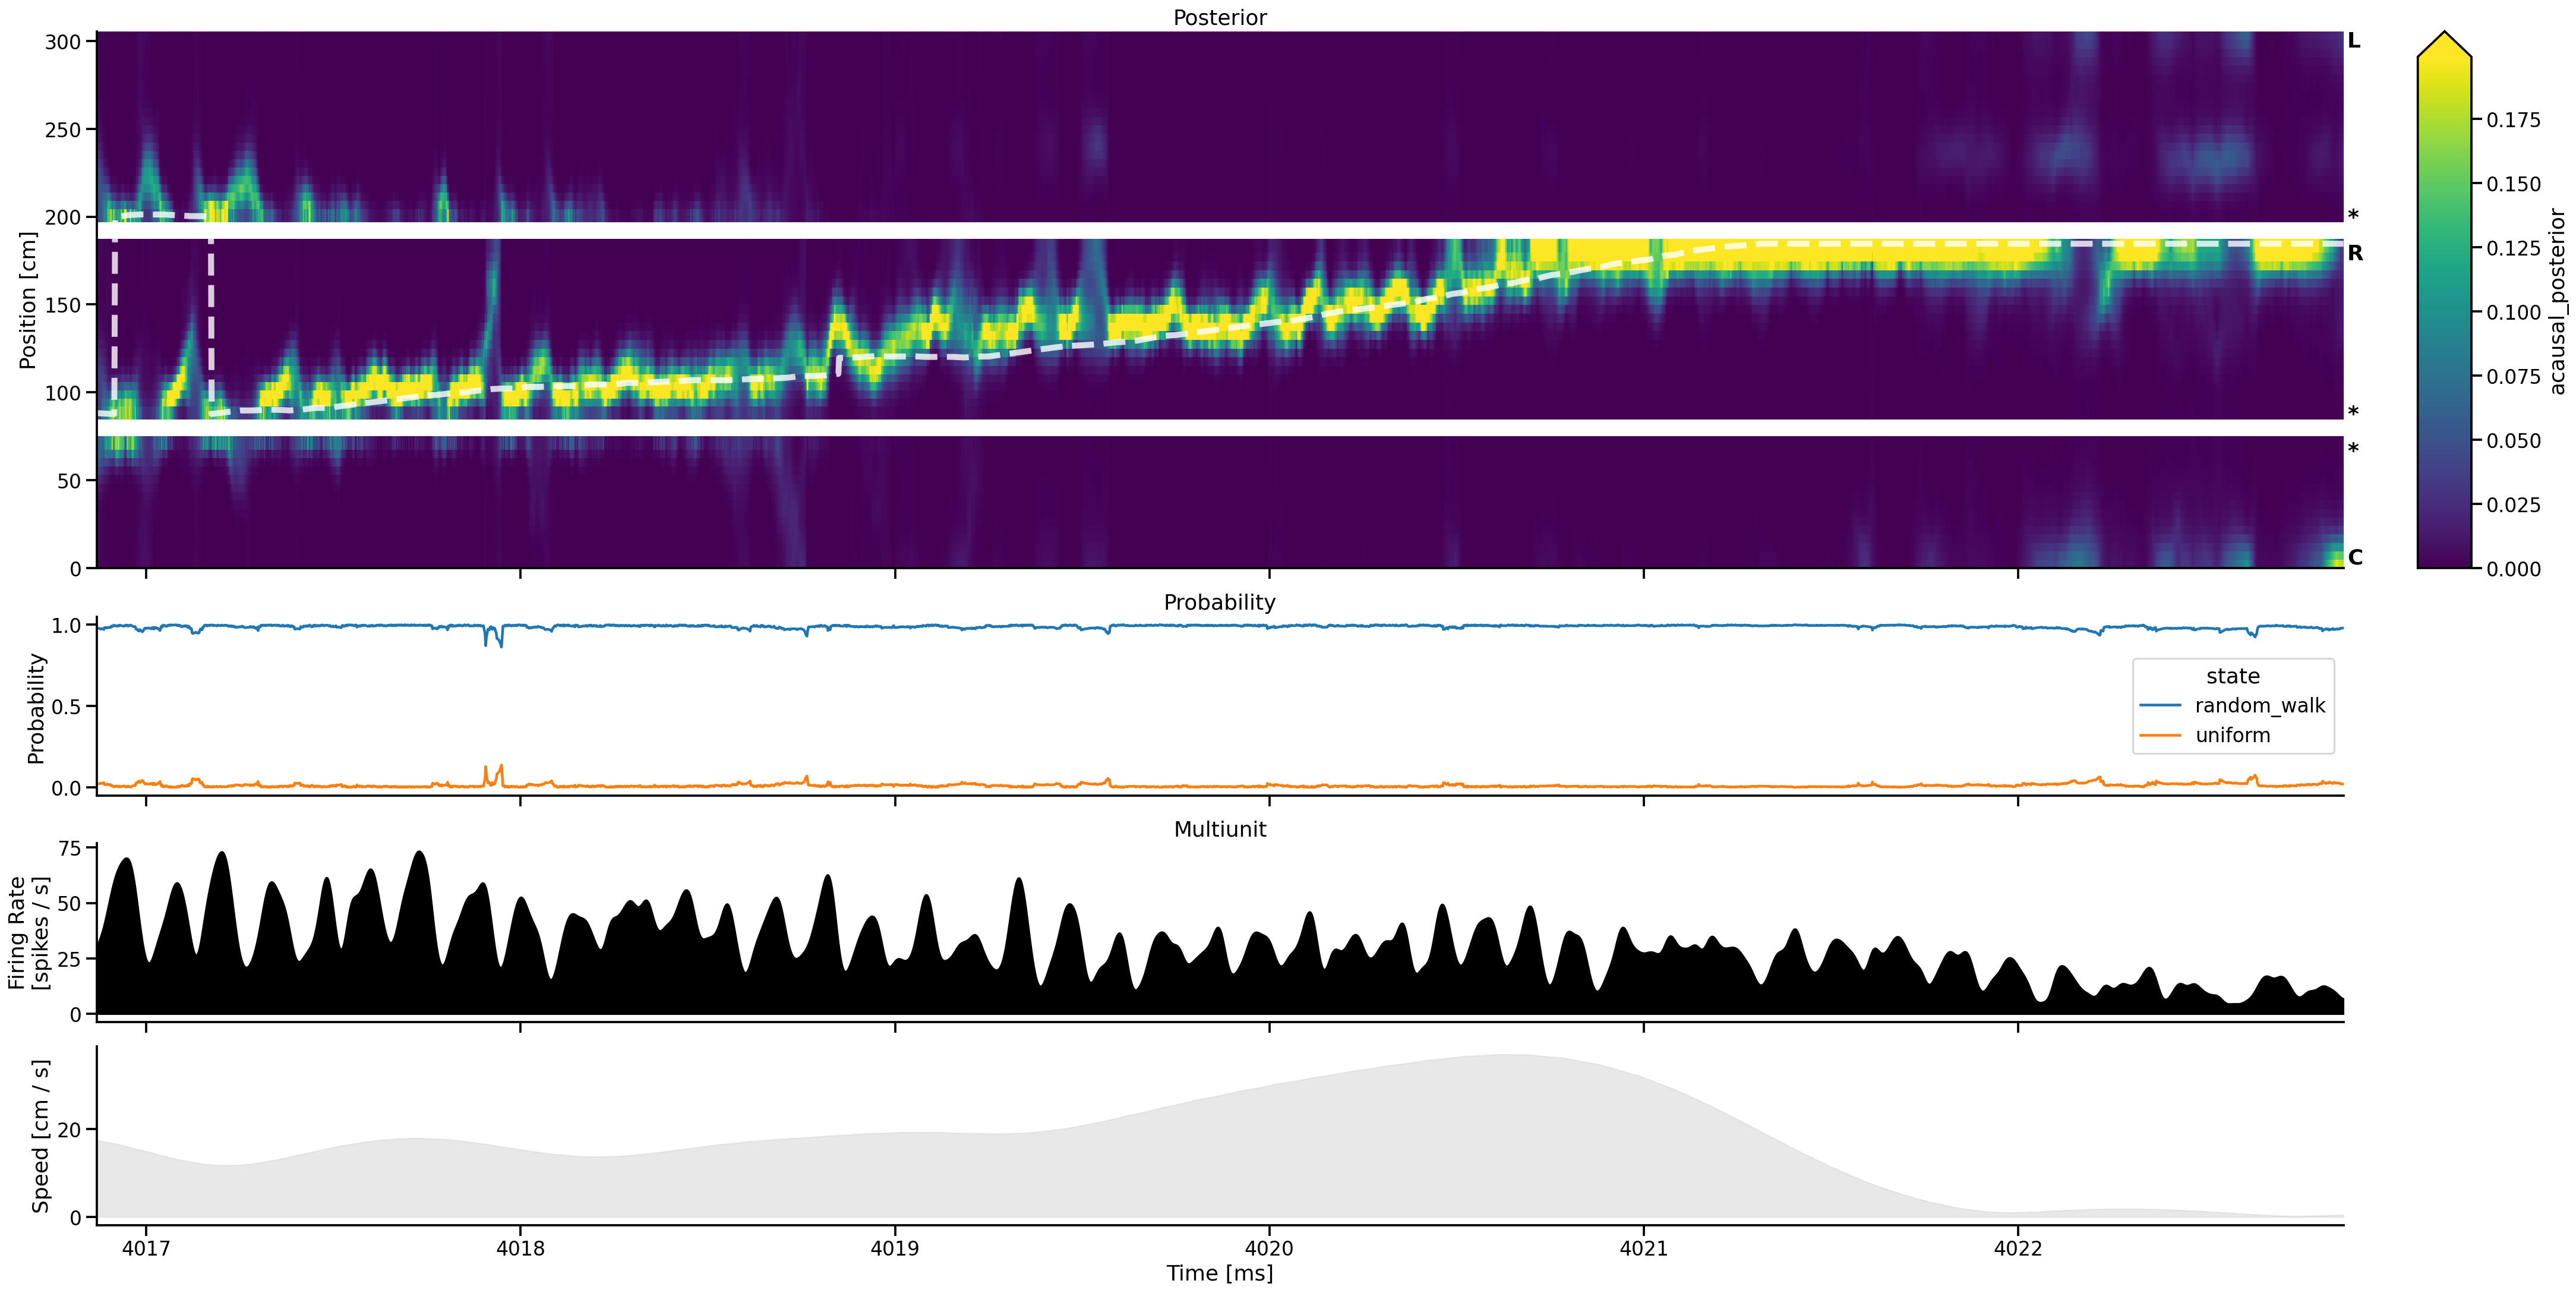

In [55]:
# extrat the time slice from the data but only is_running ones

# t = data["position_info"].index[np.where(is_running)[0]] / np.timedelta64(1, "s")
t = data["position_info"].index / np.timedelta64(1, "s")
# time_slice = slice(t.min() + 240.85, t.min() + 298.85)
time_slice = slice(t.min() + 370.85, t.min() + 376.85)
plot_local_non_local_time_slice_classifier(
    time_slice, classifier, cv_classifier_clusterless_results, data
)

In [35]:
t = data["position_info"].index[np.where(is_running)[0]] / np.timedelta64(1, "s")

In [39]:
np.where(is_running)

(array([     0,      1,      2, ..., 461586, 461587, 461588]),)

## Load classifier results and position info from processed data folder

In [13]:
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import signal
import pickle
from scipy.signal import hilbert

In [14]:
def bandpassfilter(data, lowcut=5, highcut=11, fs=500):
    """
    band pass filter of the signal
    Created by Zilong, 30/08/2021
    """
    lowcut = 5
    highcut = 11
    order = 5
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype="band")
    filtereddata = signal.filtfilt(b, a, data)

    return filtereddata

In [15]:
def get_zero_phase(filtered_lfp):
    """
    get the zero phase of the filtered lfp using hilbert transform
    """
    filtered_lfp = filtered_lfp.values.squeeze()
    analytic_signal = hilbert(filtered_lfp)
    instantaneous_phase = np.unwrap(np.angle(analytic_signal))
    # wrap the instantaneous_phase to -pi and pi
    instantaneous_phase = np.mod(instantaneous_phase + np.pi, 2 * np.pi) - np.pi
    # find phase of 0 and mark all of them as a red point on the plot
    zero_phase = np.where(
        np.logical_and(instantaneous_phase > -3.15, instantaneous_phase < -3.0)
    )[0]

    # if successive zero phase is less than 10, only keep the first one
    splits = np.split(zero_phase, np.where(np.diff(zero_phase) > 10)[0] + 1)

    # rremove empty in splits
    splits = [split for split in splits if len(split) > 0]

    zero_phase_index = np.array([split[0] for split in splits])

    return zero_phase_index

In [16]:
def plot_thetasweeps(time_slice, results, data, add_zero_phase_index=False):

    """
    Modified from https://github.com/edeno/replicate_kenny_analysis/blob/master/notebooks/Bond_day8_Epoch4.ipynb
    by Zilong, 30/08/2023
    plor the theta sweeps in time_slice
    Input:
        time_slice: the time slice to plot
        results: the classification results (cross-validated)
        data: the data dictionary
    Output:
        a plot with 4 subplots
    """

    cmap = plt.cm.inferno
    cmap.set_bad("white", alpha=0.0)

    fig, axes = plt.subplots(
        6,
        1,
        figsize=(30, 25),
        sharex=True,
        constrained_layout=True,
        gridspec_kw={"height_ratios": [1, 3, 1, 1, 1, 1]},
    )

    # ax 0: lfp from CA3
    ind = 0
    lfp = (
        data["lfps"]
        .reset_index(drop=True)
        .set_index(data["lfps"].index / np.timedelta64(1, "s"))
    )

    # plot as curve, not fill
    axes[0].plot(
        lfp.loc[time_slice].index.values,
        lfp.loc[time_slice].iloc[:, ind].values.squeeze(),
        color="lightgrey",
    )
    axes[0].set_ylabel("LFP")
    axes[0].set_title("LFP")

    # add band passs filter to lfp.iloc[:,0], using band between 5-11Hz
    lfp0 = bandpassfilter(lfp.iloc[:, ind], lowcut=5, highcut=11, fs=500)
    # group the lfp0 into dataframe with time index
    lfp0 = pd.DataFrame(lfp0, index=lfp.index)

    # calculate the zero phase index
    zero_phase_index = get_zero_phase(lfp0[time_slice])

    # plot the filtered lfp
    axes[0].plot(
        lfp.loc[time_slice].index.values, lfp0[time_slice], color="black", linewidth=2
    )

    # print(lfp0[time_slice].index.values[zero_phase_index])
    # print(lfp0[time_slice].values.squeeze()[zero_phase_index])

    axes[0].scatter(
        lfp0[time_slice].index.values[zero_phase_index],
        lfp0[time_slice].values.squeeze()[zero_phase_index],
        color="red",
        s=10,
    )

    # ax 1
    results["acausal_posterior"].sum("state", skipna=False).sel(time=time_slice).plot(
        x="time",
        y="position",
        robust=True,
        ax=axes[1],
        cmap=cmap,
        vmin=0.0,
    )

    arm_min_max = (
        data["position_info"]
        .groupby("arm_name")
        .linear_position.aggregate(["min", "max"])
    )
    max_time = results.sel(time=time_slice).time.max() + 0.01
    axes[1].text(
        max_time,
        arm_min_max.loc["Center Arm", "min"],
        "C",
        ha="left",
        va="bottom",
        weight="bold",
    )
    axes[1].text(
        max_time,
        arm_min_max.loc["Center Arm", "max"],
        "*",
        ha="left",
        va="top",
        weight="bold",
    )
    axes[1].text(
        max_time,
        arm_min_max.loc["Right Arm", "max"],
        "R",
        ha="left",
        va="top",
        weight="bold",
    )
    axes[1].text(
        max_time,
        arm_min_max.loc["Right Arm", "min"],
        "*",
        ha="left",
        va="center",
        weight="bold",
    )
    axes[1].text(
        max_time,
        arm_min_max.loc["Left Arm", "max"],
        "L",
        ha="left",
        va="top",
        weight="bold",
    )
    axes[1].text(
        max_time,
        arm_min_max.loc["Left Arm", "min"],
        "*",
        ha="left",
        va="center",
        weight="bold",
    )
    axes[1].set_ylabel("Position [cm]")

    axes[1].set_title("Posterior")

    axes[1].plot(
        data["position_info"].reset_index().set_index(t).loc[time_slice].index,
        data["position_info"]
        .reset_index()
        .set_index(t)
        .loc[time_slice]
        .linear_position,
        color="white",
        linestyle="--",
        linewidth=5,
        alpha=0.8,
    )
    axes[1].set_xlabel("")

    if add_zero_phase_index:
        # add multiple vertical lines to indicate the zero phase
        for i in zero_phase_index:
            axes[1].axvline(
                x=lfp0[time_slice].index.values[i],
                color="grey",
                linestyle="--",
                linewidth=2,
            )

    # ax 2
    results.mental_distance_from_actual_position.sel(time=time_slice).plot(
        x="time", ax=axes[2], color="black", linewidth=2
    )

    if add_zero_phase_index:
        # add multiple vertical lines to indicate the zero phase
        for i in zero_phase_index:
            axes[2].axvline(
                x=lfp0[time_slice].index.values[i],
                color="grey",
                linestyle="--",
                linewidth=2,
            )

    # ax 3
    results["acausal_posterior"].sum("position").sel(time=time_slice).plot(
        x="time", hue="state", ax=axes[3], linewidth=2
    )
    axes[3].set_title("Probability")
    axes[3].set_ylabel("Probability")
    axes[3].set_xlabel("")

    # ax 4
    multiunit_firing = (
        data["multiunit_firing_rate"]
        .reset_index(drop=True)
        .set_index(data["multiunit_firing_rate"].index / np.timedelta64(1, "s"))
    )

    axes[4].fill_between(
        multiunit_firing.loc[time_slice].index.values,
        multiunit_firing.loc[time_slice].values.squeeze(),
        color="black",
    )
    axes[4].set_ylabel("Firing Rate\n[spikes / s]")
    axes[4].set_title("Multiunit")

    # ax 5
    axes[5].fill_between(
        data["position_info"].reset_index().set_index(t).loc[time_slice].index,
        data["position_info"]
        .reset_index()
        .set_index(t)
        .loc[time_slice]
        .speed.values.squeeze(),
        color="lightgrey",
        linewidth=1,
        alpha=0.5,
    )
    axes[5].set_ylabel("Speed [cm / s]")
    axes[5].set_xlabel("Time [ms]")
    sns.despine()

In [17]:
from src.load_data import load_data

epoch_key = ("fra", 3, 4)

data = load_data(epoch_key, exclude_interneuron_spikes=True)

Failed to load file: /home/zilong/Desktop/replay_trajectory_paper/Raw-Data/Frank/fraDIO03.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /home/zilong/Desktop/replay_trajectory_paper/Raw-Data/Frank/fraDIO03.mat
No DIO file found, inferring correct inbound/outbound from task rules
Failed to load file: /home/zilong/Desktop/replay_trajectory_paper/Raw-Data/Frank/fraDIO03.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /home/zilong/Desktop/replay_trajectory_paper/Raw-Data/Frank/fraDIO03.mat
No DIO file found, inferring correct inbound/outbound from task rules


In [100]:
data['spikes']

fra_03_04_001_001  fra_03_04_001_002  fra_03_04_004_001  \
time                                                                       
01:32:21.023900                  0                  0                  0   
01:32:21.025900                  0                  0                  0   
01:32:21.027900                  0                  0                  0   
01:32:21.029900                  0                  0                  0   
01:32:21.031900                  0                  0                  0   
...                            ...                ...                ...   
01:48:28.997900                  0                  0                  0   
01:48:28.999900                  0                  0                  0   
01:48:29.001900                  0                  0                  0   
01:48:29.003900                  0                  0                  0   
01:48:29.005900                  0                  0                  0   

                 fra_03_04_004_002  fra_03_04_027_003  fra_03_04_028_004  
time                                                                      
01:32:21.023900                  0                  0                  0  
01:32:21.025900                  0                  0                  0  
01:32:21.027900                  0                  0                  0  
01:32:21.029900                  0                  0                  0  
01:32:21.031900                  0                  0                  0  
...                            ...                ...                ...  
01:48:28.997900                  0                  0                  0  
01:48:28.999900                  0                  0                  0  
01:48:29.001900                  0                  0                  0  
01:48:29.003900                  0                  0                  0  
01:48:29.005900                  0                  0                  0  

[483992 rows x 6 columns]

In [41]:
epoch_key = ("fra", 2, 2)

data2 = load_data(epoch_key, exclude_interneuron_spikes=True)

Failed to load file: /home/zilong/Desktop/replay_trajectory_paper/Raw-Data/Frank/fraDIO02.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /home/zilong/Desktop/replay_trajectory_paper/Raw-Data/Frank/fraDIO02.mat
No DIO file found, inferring correct inbound/outbound from task rules
Failed to load file: /home/zilong/Desktop/replay_trajectory_paper/Raw-Data/Frank/fraDIO02.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /home/zilong/Desktop/replay_trajectory_paper/Raw-Data/Frank/fraDIO02.mat
No DIO file found, inferring correct inbound/outbound from task rules


In [18]:
datafolder = (
    "/home/zilong/Desktop/replay_trajectory_paper/Processed-Data/ThetaSweepTrajectories"
)

# load the classifier results
cv_classifier_clusterless_results = xr.open_dataset(
    os.path.join(datafolder, "fra_03_04_cv_classifier_clusterless_results.nc")
)

# # load the data with pickle
# with open(os.path.join(datafolder, "bon_08_04_data.pkl"), "rb") as f:
#     data = pickle.load(f)

# get time slice
t = data["position_info"].index / np.timedelta64(1, "s")

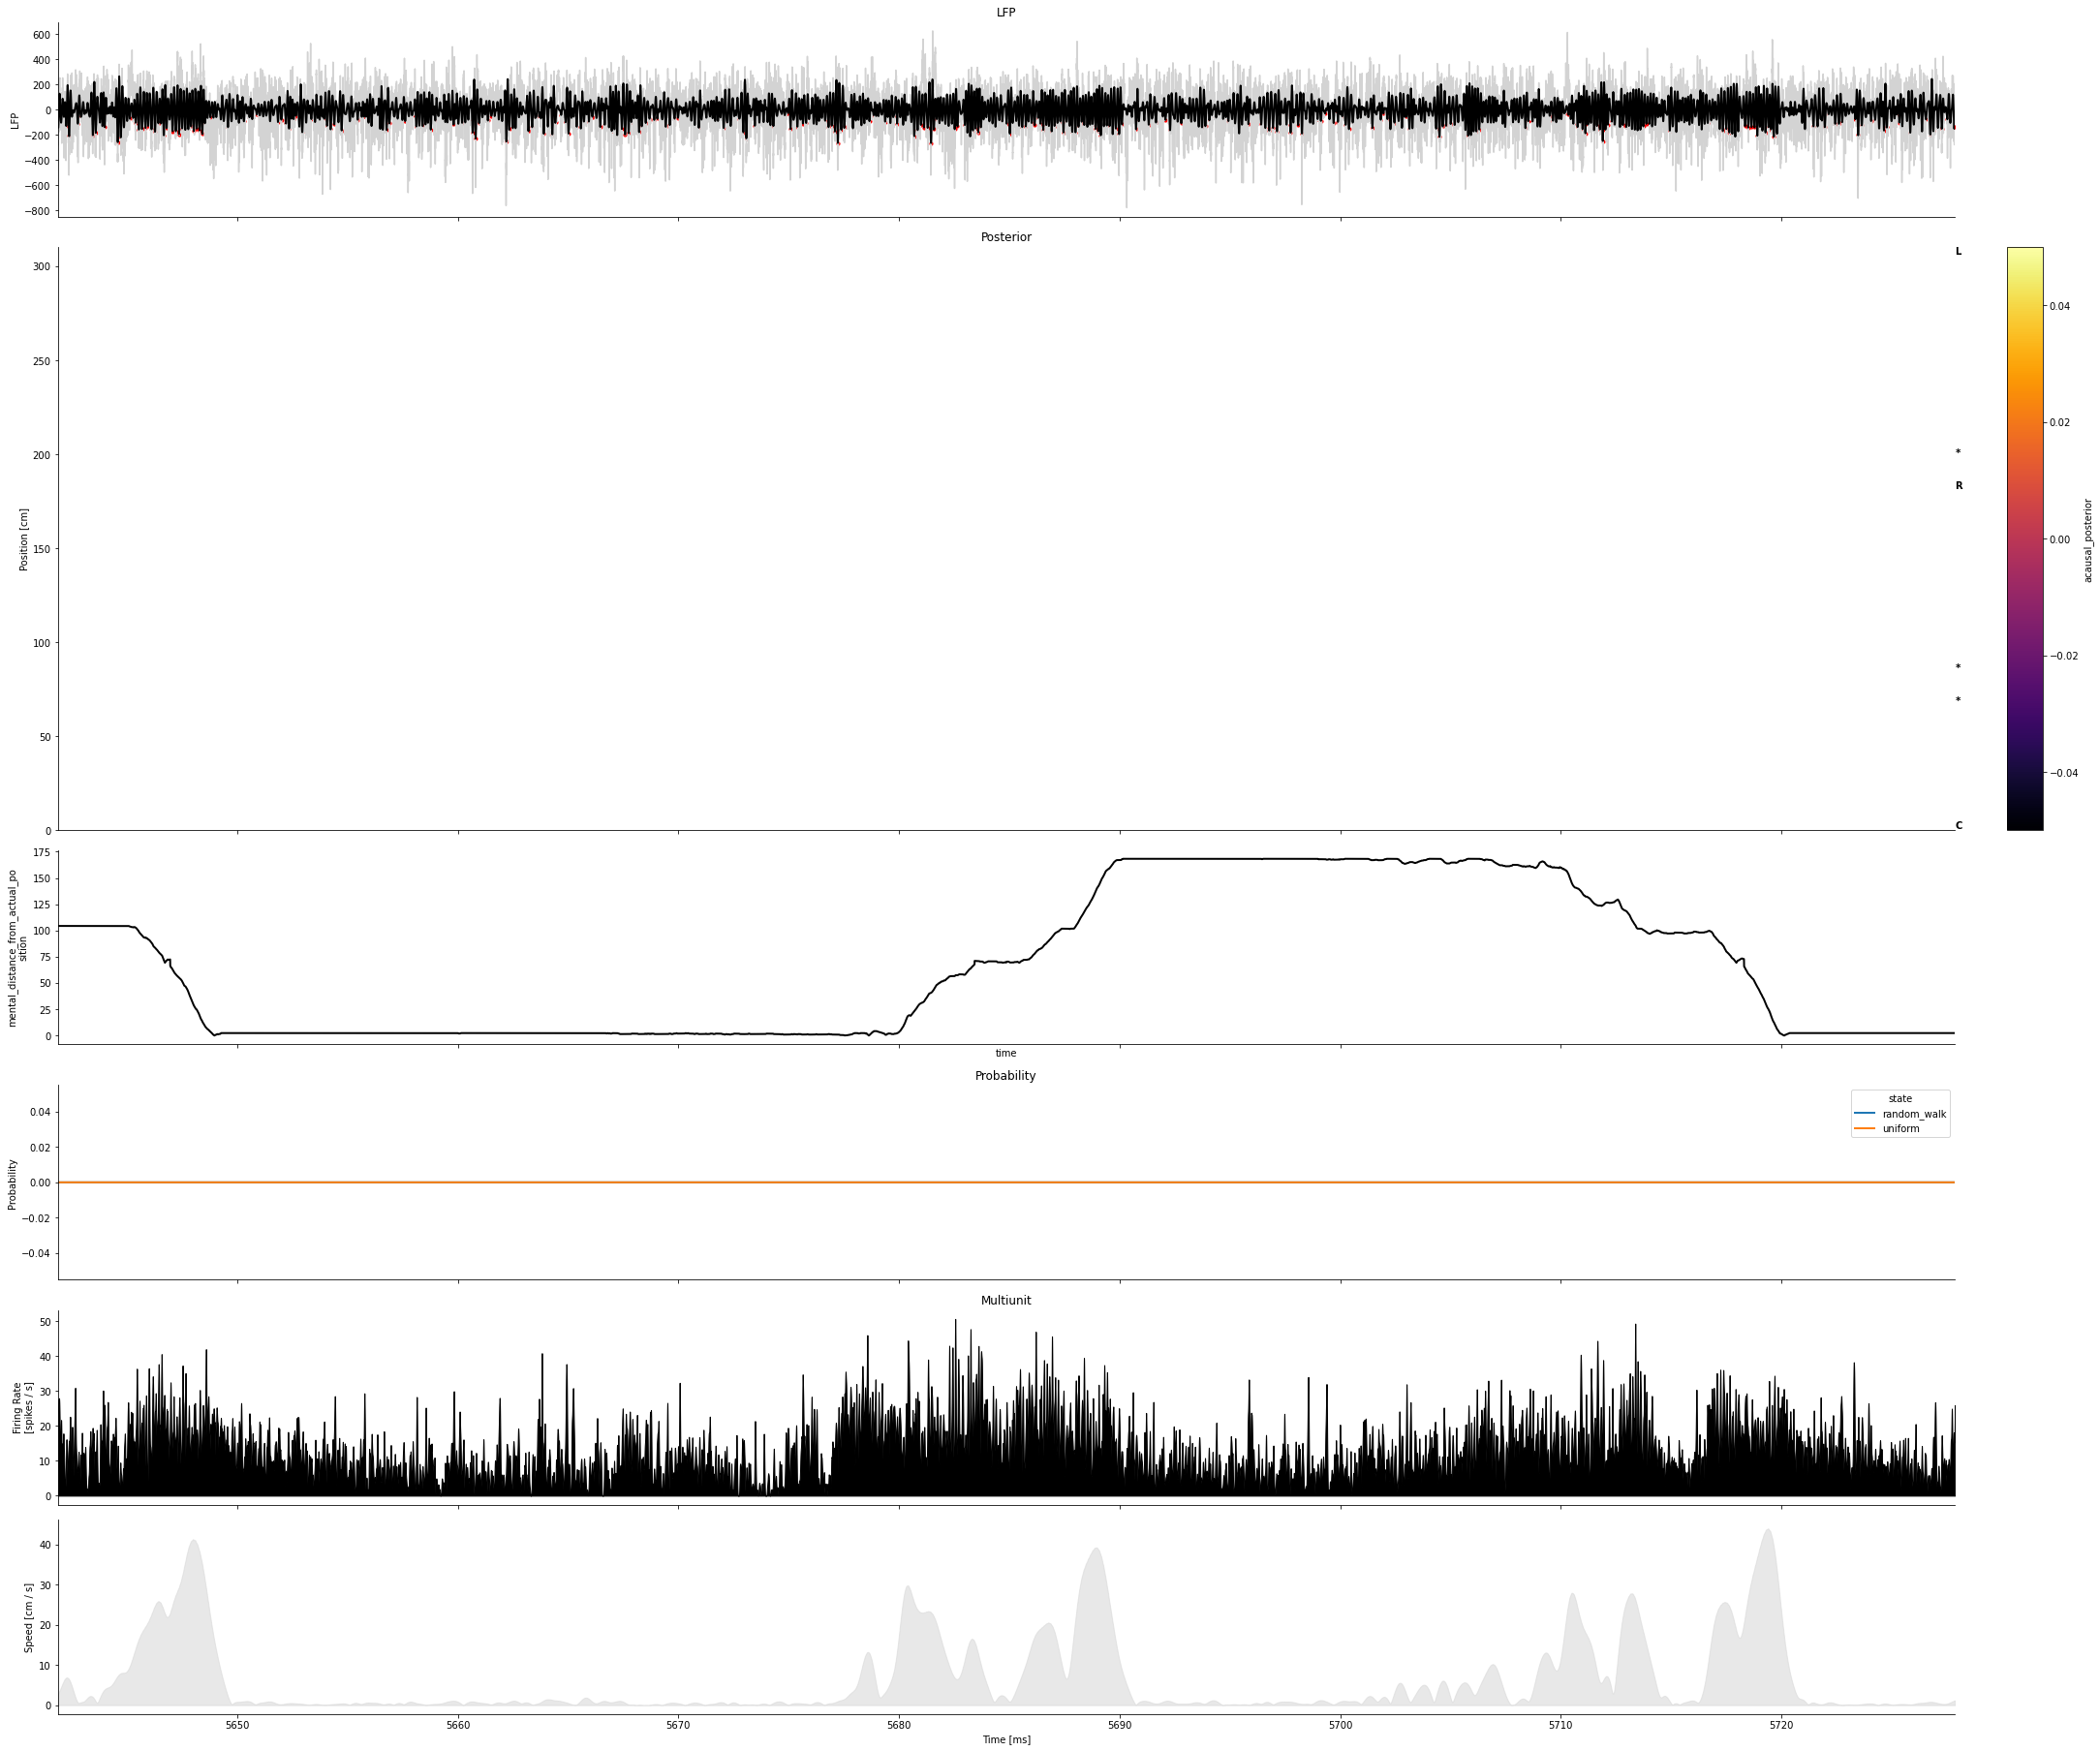

In [20]:
time_slice = slice(t.min() + 100.85, t.min() + 186.85)
plot_thetasweeps(
    time_slice, cv_classifier_clusterless_results, data, add_zero_phase_index=False
)

In [21]:
cv_classifier_clusterless_results.acausal_posterior

<xarray.DataArray 'acausal_posterior' (time: 483992, state: 2, position: 61)>
array([[[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       ...,

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]]])
Coordinates:
  * time      (time) float64 5.541e+03 5.541e+03 ... 6.509e+03 6.509e+03
  * position  (position) float64 2.39 7.171 11.95 16.73 ... 297.9 302.8 307.8
  * state     (state) object 'random_walk' 'uniform'

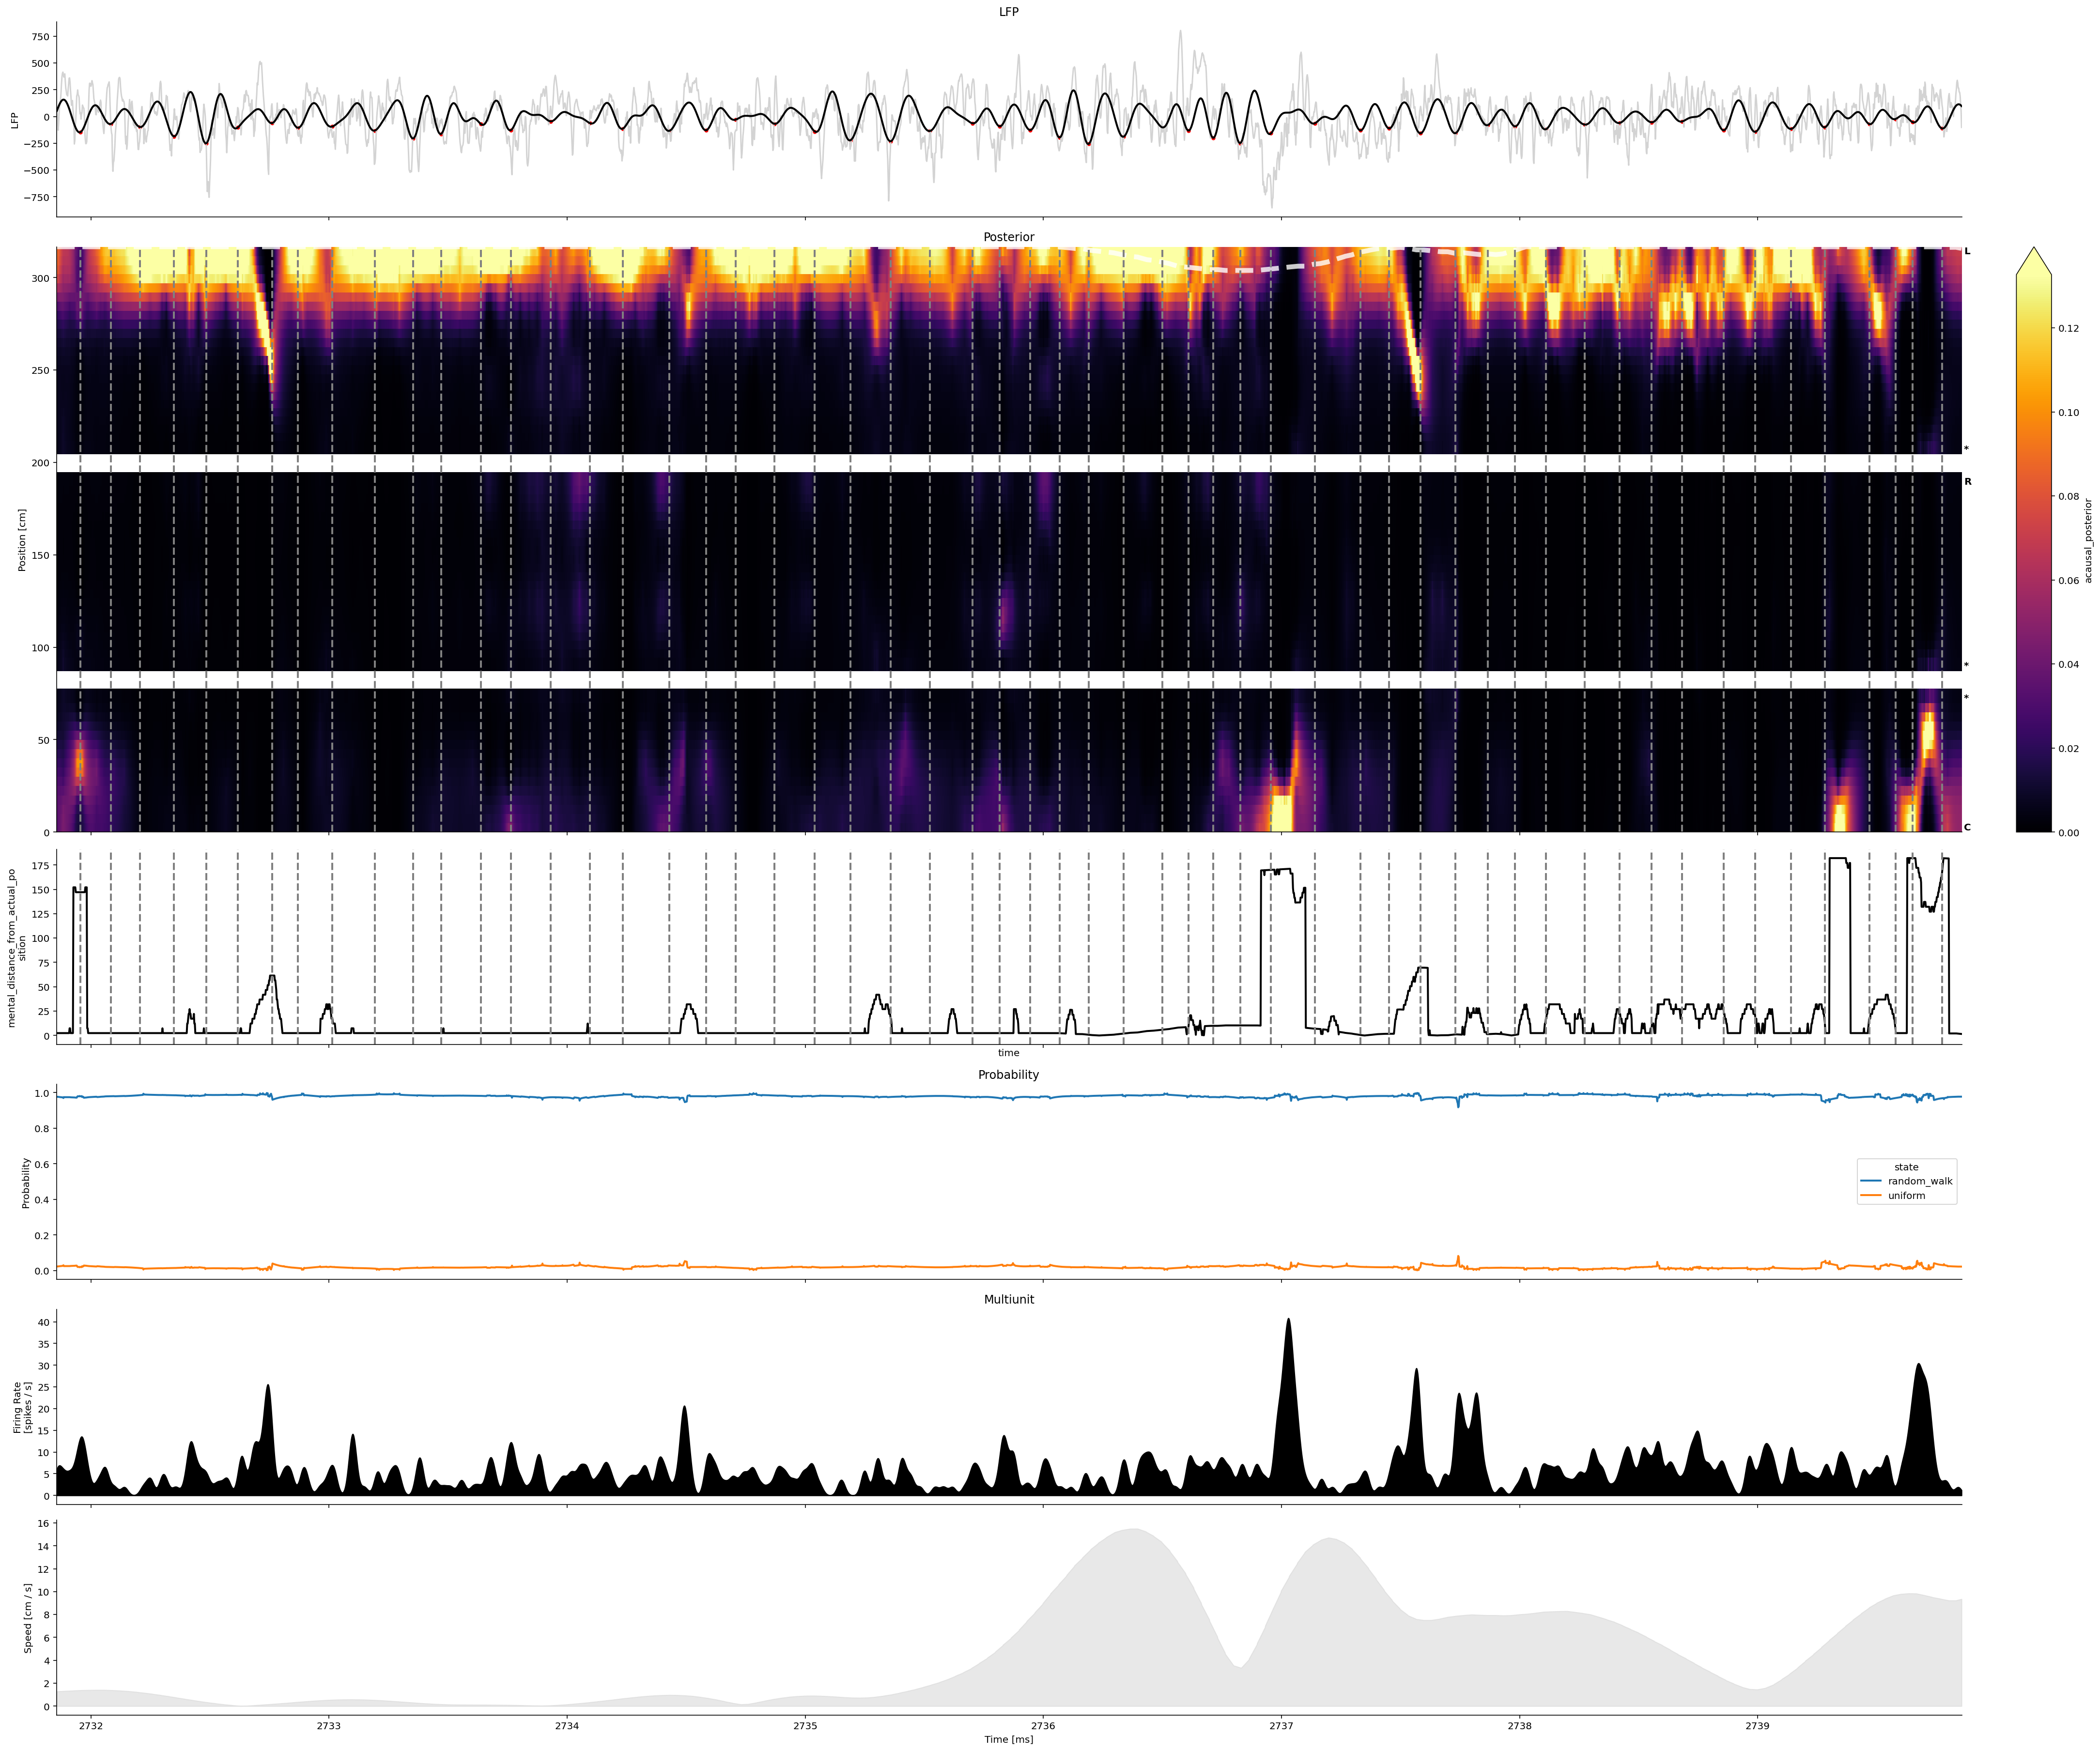

In [12]:
time_slice = slice(t.min() + 258.85, t.min() + 266.85)
plot_thetasweeps(
    time_slice, cv_classifier_clusterless_results, data, add_zero_phase_index=True
)

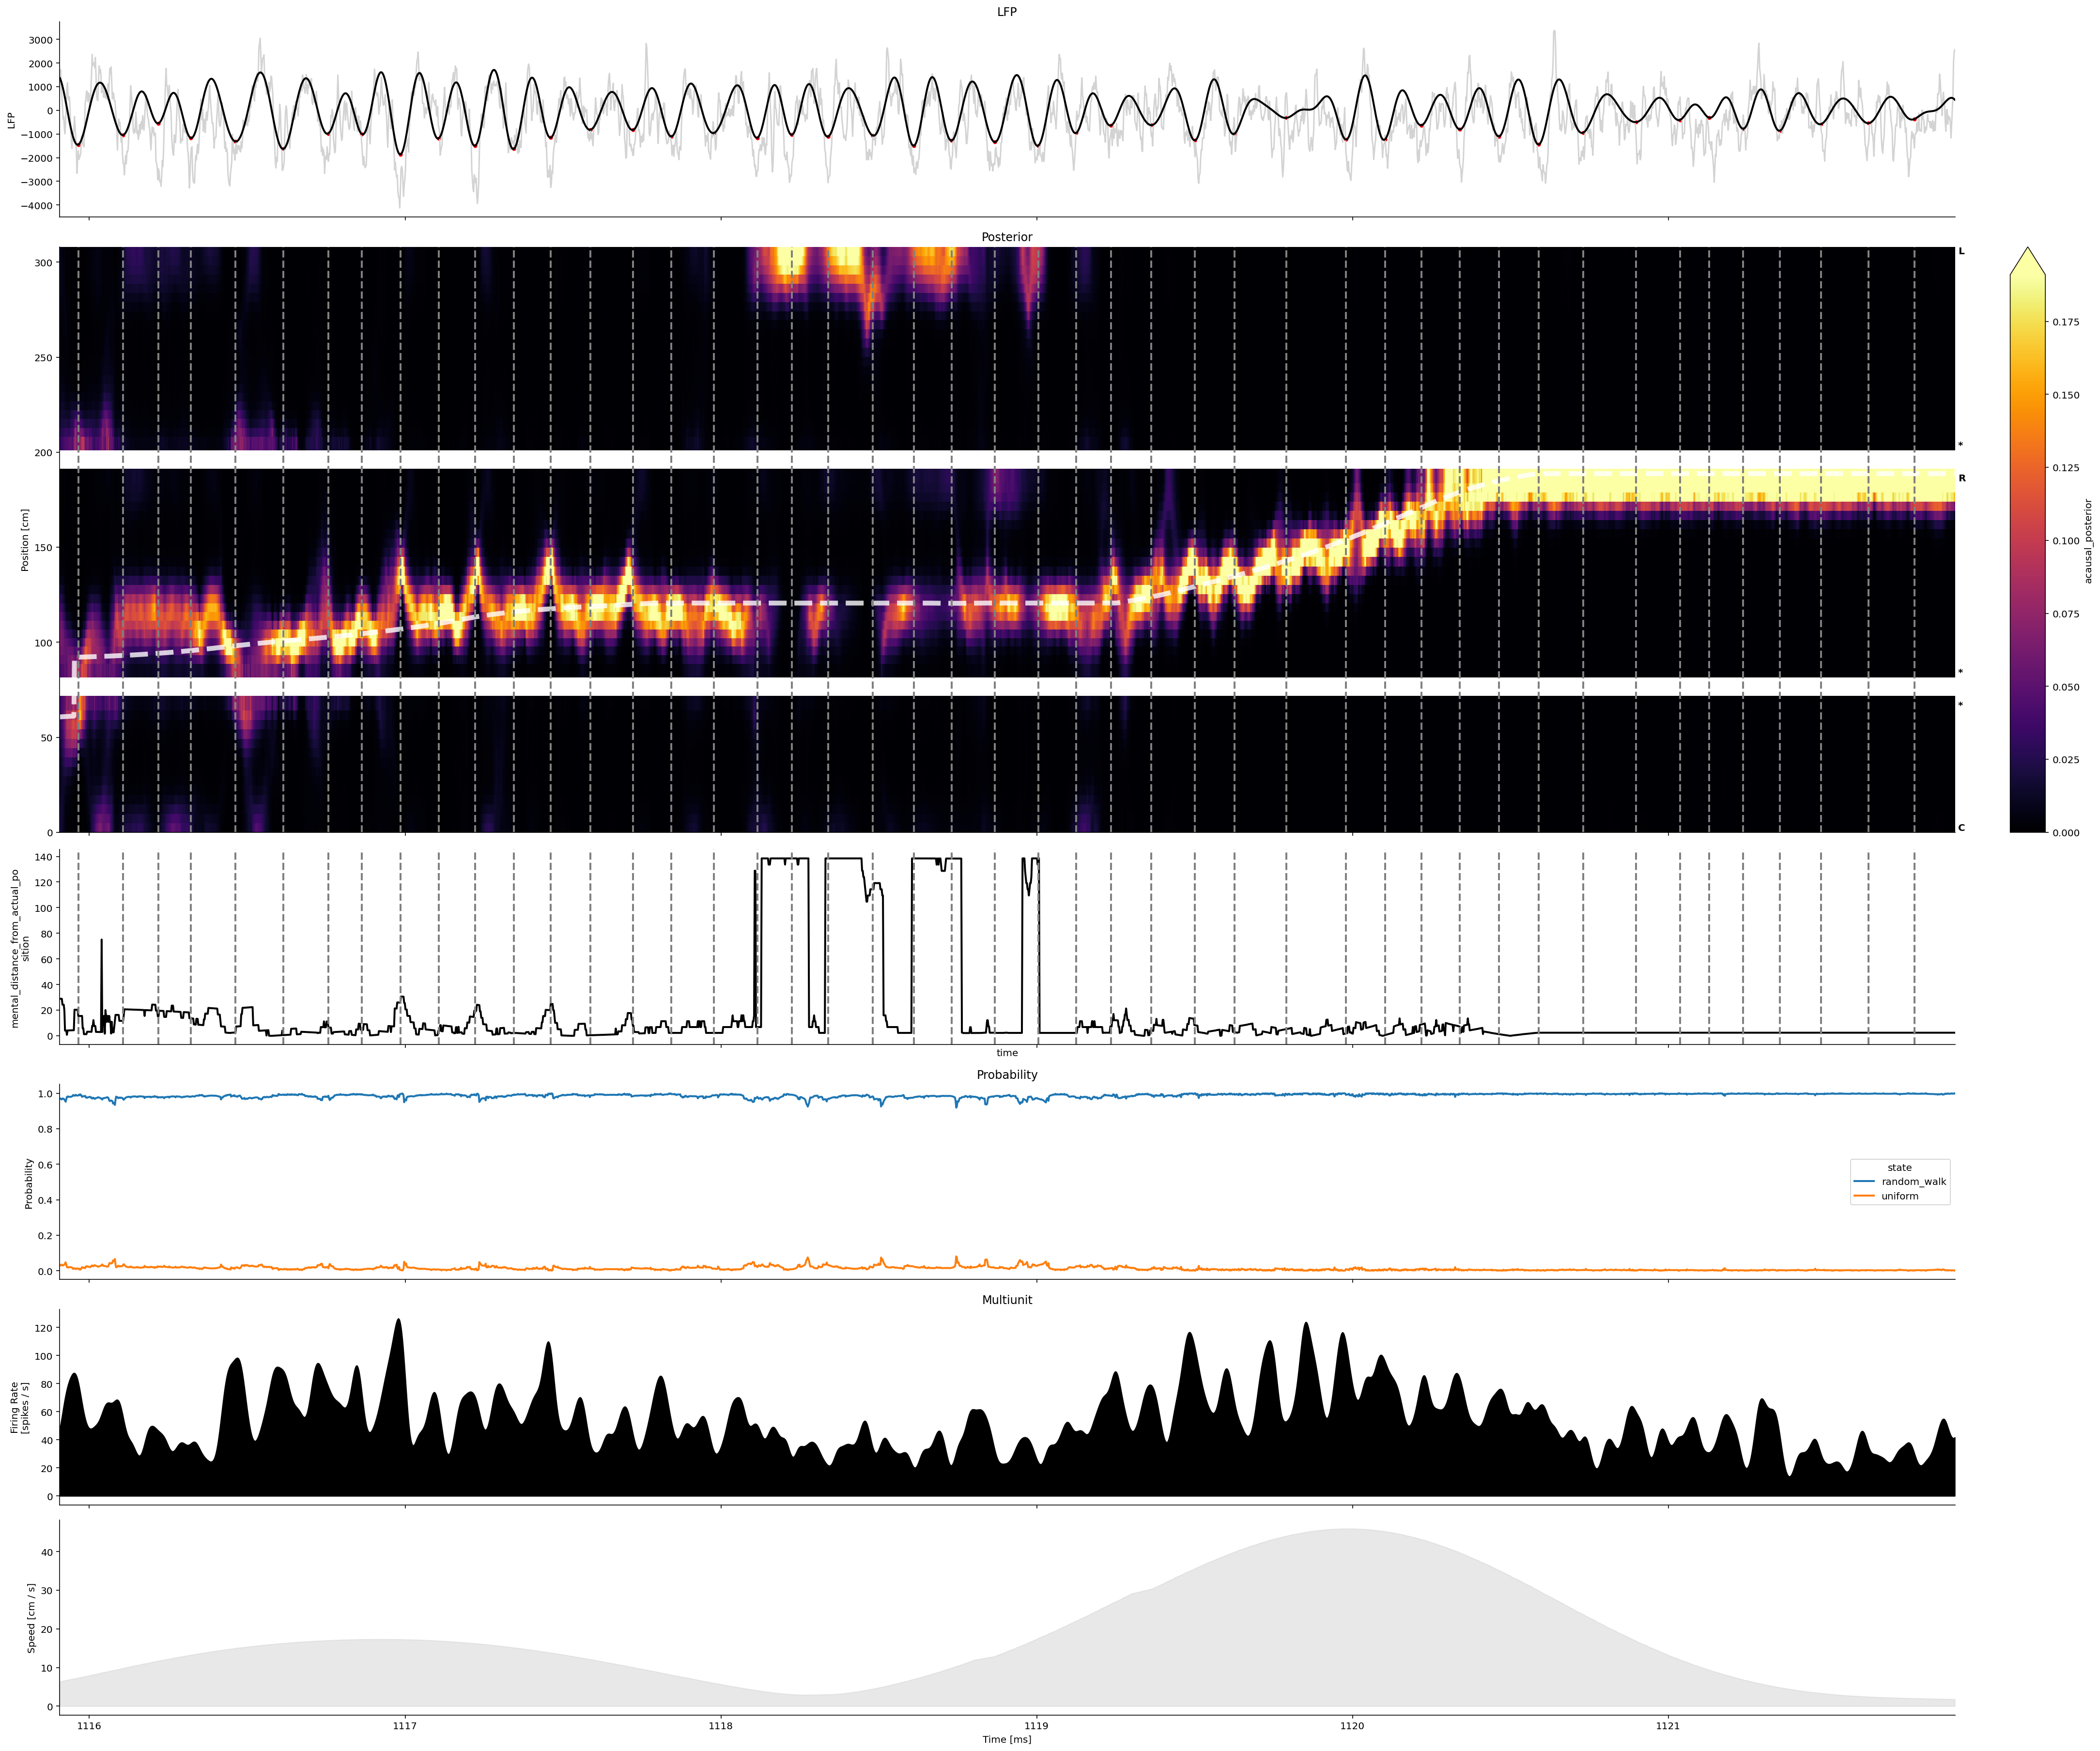

In [11]:
time_slice = slice(t.min() + 222.85, t.min() + 228.85)
plot_thetasweeps(
    time_slice, cv_classifier_clusterless_results, data, add_zero_phase_index=True
)

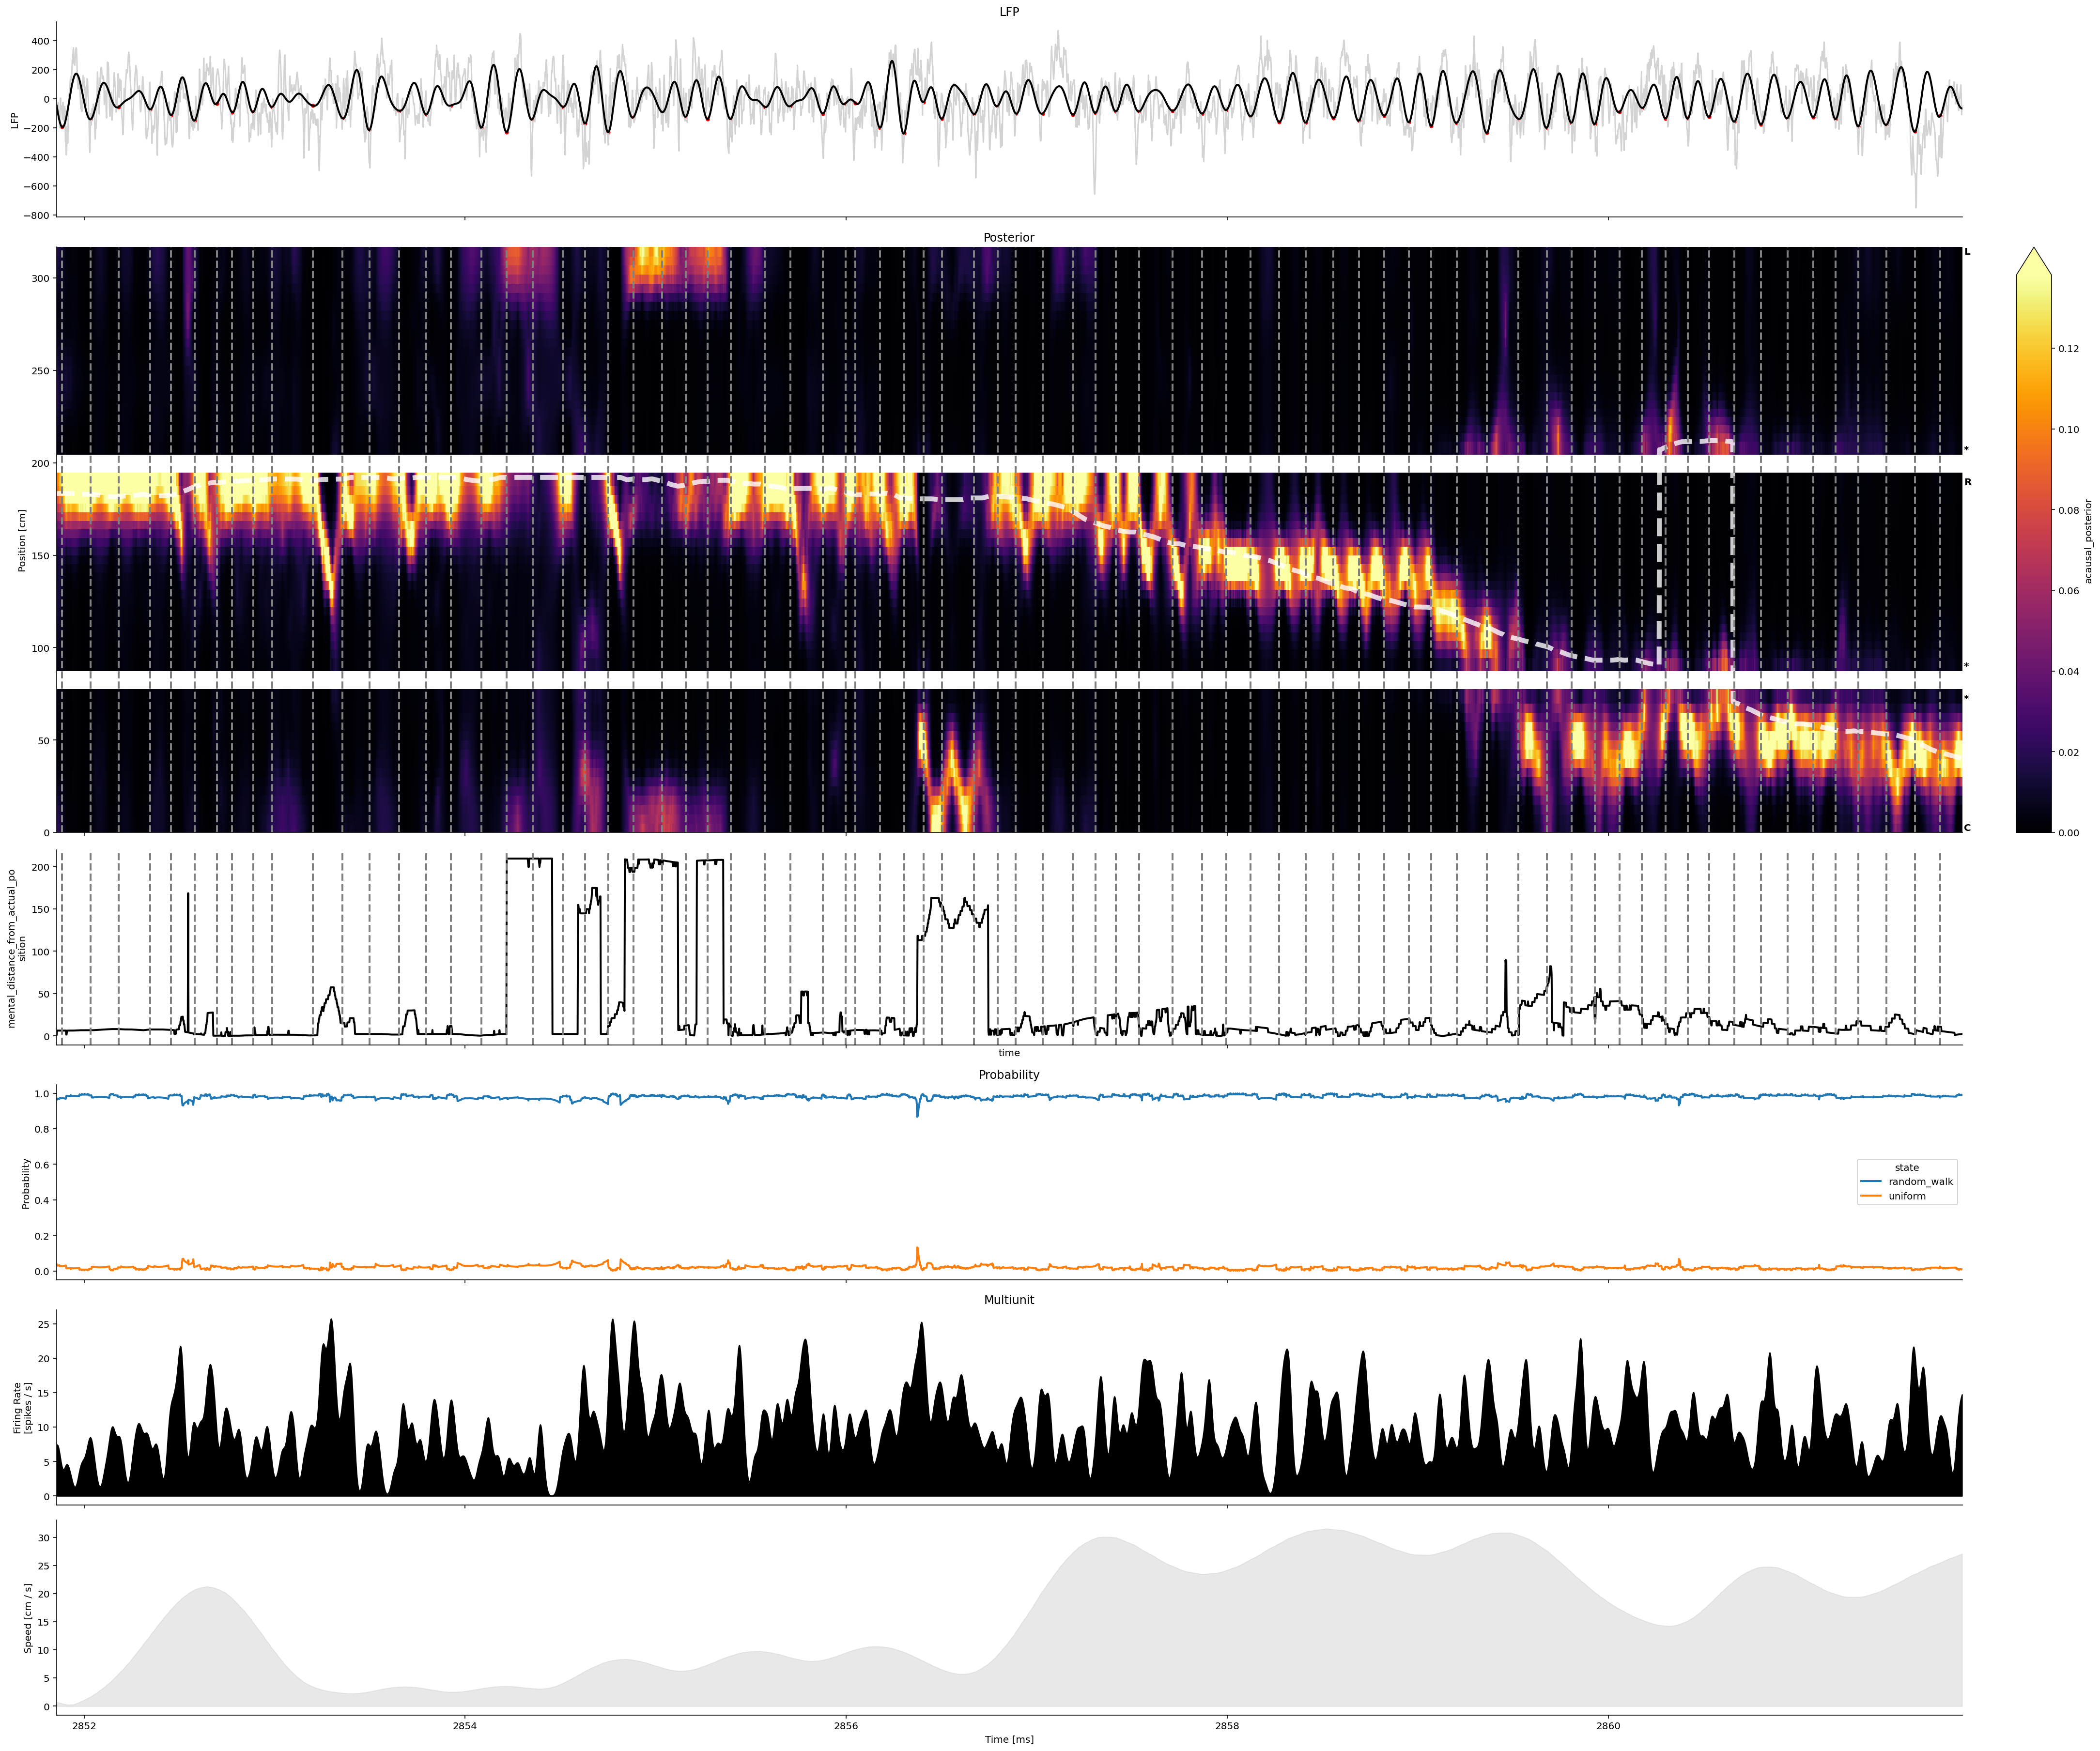

In [17]:
time_slice = slice(t.min() + 378.85, t.min() + 388.85)
plot_thetasweeps(
    time_slice, cv_classifier_clusterless_results, data, add_zero_phase_index=True
)

## Get the mean theta sweep amplitude


In [67]:
datafolder = (
    "/home/zilong/Desktop/replay_trajectory_paper/Processed-Data/ThetaSweepTrajectories"
)

# load the classifier results
cv_classifier_clusterless_results = xr.open_dataset(
    os.path.join(datafolder, "bon_09_06_cv_classifier_clusterless_results.nc")
)

# load the data with pickle
with open(os.path.join(datafolder, "bon_09_06_data.pkl"), "rb") as f:
    data = pickle.load(f)

# get time slice
t = data["position_info"].index / np.timedelta64(1, "s")

In [82]:
#extract speed from data and threshold it with 10 cm/s
speed = data['position_info'].speed.values
is_running = (speed > 0) & (speed < 4)

sweeps_dist_in_running = cv_classifier_clusterless_results.mental_distance_from_actual_position[is_running]

np.mean(sweeps_dist_in_running)

<xarray.DataArray 'mental_distance_from_actual_position' ()>
array(48.53226815)

In [24]:
def get_sweep_amp_each_theta_cycle(lfp0_in_running, sweeps_dist_in_running):
    """
    get the amplitude of each sweep in each theta cycle
    Input:
        lfp0_in_running: the filtered lfp in running
        sweeps_dist_in_running: the mental distance of each sweep in running
    """
    # get the zero phase index
    zero_phase_index = get_zero_phase(lfp0_in_running)

    # if zero_phase_index is empty, return None
    if len(zero_phase_index) == 0:
        return None

    # if first zero phase index is 0, remove it
    if zero_phase_index[0] == 0:
        zero_phase_index = zero_phase_index[1:]

    # split the sweeps_dist_in_running according to the zero phase index
    # and extract the largest sweep_dist in each theta cycle
    splits = np.split(sweeps_dist_in_running, zero_phase_index)

    sweep_amp_each_theta_cycle = np.array([np.max(split) for split in splits])

    return sweep_amp_each_theta_cycle

In [75]:
lfp = (
    data["lfps"]
    .reset_index(drop=True)
    .set_index(data["lfps"].index / np.timedelta64(1, "s"))
)

ind = 0
# add band passs filter to lfp.iloc[:,0], using band between 5-11Hz
lfp0 = bandpassfilter(lfp.iloc[:, ind], lowcut=5, highcut=11, fs=500)
# group the lfp0 into dataframe with time index
lfp0 = pd.DataFrame(lfp0, index=lfp.index)

speed = data["position_info"].speed.values
# is_running = speed > 10
is_running = (speed > 32) & (speed < 36)

lfp0_in_running = lfp0[is_running]

zero_phase_index_in_running = get_zero_phase(lfp0_in_running)

sweeps_dist_in_running = (
    cv_classifier_clusterless_results.mental_distance_from_actual_position[is_running]
)


# get the sweeps_dist_in_running each theta cycle
sweep_amp_each_cycle = get_sweep_amp_each_theta_cycle(
    lfp0_in_running, sweeps_dist_in_running
)

# print mean sweep_amp_each_cycle
print(np.mean(sweep_amp_each_cycle))
# print median
print(np.median(sweep_amp_each_cycle))

48.625987511815026
28.446068217228408


Text(0.5, 1.0, 'Sweep Amplitude Distribution')

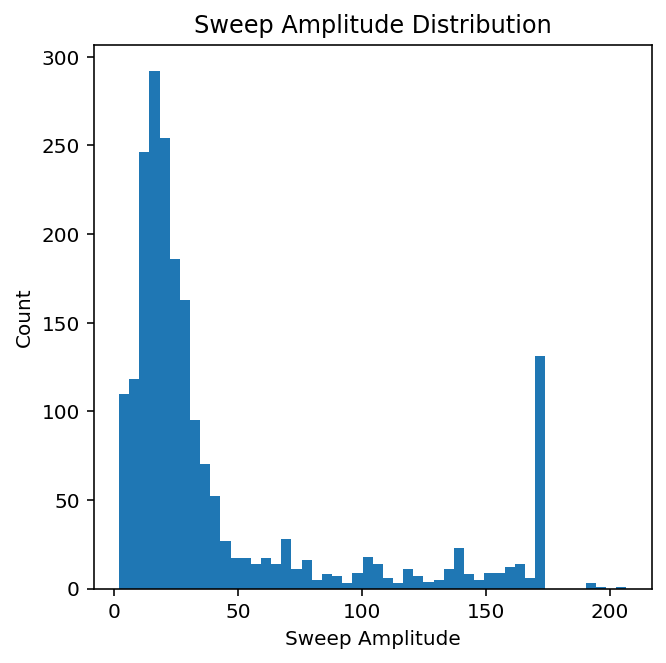

In [36]:
# plot hist of sweep_amp_each_cycle
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.hist(sweep_amp_each_cycle, bins=50)
ax.set_xlabel("Sweep Amplitude")
ax.set_ylabel("Count")
ax.set_title("Sweep Amplitude Distribution")

In [32]:
len(zero_phase_index_in_running)

2079

## plot Sweep amp against speed for animal bon

In [1]:
from loren_frank_data_processing import make_epochs_dataframe, make_neuron_dataframe
from src.parameters import ANIMALS, MAX_N_EXPOSURES, MIN_N_NEURONS
from tqdm.auto import tqdm

epoch_info = make_epochs_dataframe(ANIMALS)
neuron_info = make_neuron_dataframe(ANIMALS)
n_neurons = (
    neuron_info.groupby(["animal", "day", "epoch"])
    .neuron_id.agg(len)
    .rename("n_neurons")
    .to_frame()
)

epoch_info = epoch_info.join(n_neurons)
is_w_track = epoch_info.environment.isin(["TrackA", "TrackB", "WTrackA", "WTrackB"])

In [4]:
#get neuron_info only for gov, day 4
neuron_info_gov = neuron_info.loc['gov', 4, :]
neuron_info_gov

area  deadchans  fs hemisphere  \
animal day epoch tetrode_number neuron_number                                  
gov    4   1     9              1               DG        NaN NaN        NaN   
                 10             1               DG        NaN NaN        NaN   
                 11             1              CA1        NaN NaN        NaN   
                                2              CA1        NaN NaN        NaN   
                 12             3              CA1        NaN NaN        NaN   
...                                            ...        ...  ..        ...   
           11    14             3              CA1        NaN NaN        NaN   
                                4              CA1        NaN NaN        NaN   
                 16             1              CA2        NaN NaN        NaN   
                                3              CA2        NaN NaN        NaN   
                 21             1              CA1        NaN NaN        NaN   

                                               meanrate  nearCA2  \
animal day epoch tetrode_number neuron_number                      
gov    4   1     9              1              0.004233      0.0   
                 10             1              0.034921      0.0   
                 11             1              0.023280      0.0   
                                2              9.659259      0.0   
                 12             3              0.062434      0.0   
...                                                 ...      ...   
           11    14             3              0.007407      1.0   
                                4              0.430199      1.0   
                 16             1              0.293447      1.0   
                                3              0.610826      1.0   
                 21             1              1.049573      0.0   

                                                       neuron_id  numspikes  \
animal day epoch tetrode_number neuron_number                                 
gov    4   1     9              1              gov_04_01_009_001        4.0   
                 10             1              gov_04_01_010_001       33.0   
                 11             1              gov_04_01_011_001       22.0   
                                2              gov_04_01_011_002     9128.0   
                 12             3              gov_04_01_012_003       59.0   
...                                                          ...        ...   
           11    14             3              gov_04_11_014_003       13.0   
                                4              gov_04_11_014_004      755.0   
                 16             1              gov_04_11_016_001      515.0   
                                3              gov_04_11_016_003     1072.0   
                 21             1              gov_04_11_021_001     1842.0   

                                               peakrate  spikewidth   subarea  \
animal day epoch tetrode_number neuron_number                                   
gov    4   1     9              1                   NaN    5.467163        DG   
                 10             1                   NaN    8.148649        DG   
                 11             1                   NaN    7.789098      CA1c   
                                2                   NaN    5.031321      CA1c   
                 12             3                   NaN    8.166477      CA1b   
...                                                 ...         ...       ...   
           11    14             3                   NaN    6.625644      CA1c   
                                4                   NaN    7.504489      CA1c   
                 16             1                   NaN   11.001703  CA2-CA3a   
                                3                   NaN    9.196980  CA2-CA3a   
                 21             1                   NaN    8.496969      CA1b   

                                      

In [8]:
is_animal = epoch_info.index.isin(["fra"], level="animal")

valid_epochs = (
    is_w_track
    & (epoch_info.n_neurons > MIN_N_NEURONS)
    & (epoch_info.exposure <= MAX_N_EXPOSURES)
    & is_animal
)

In [25]:
DATA_DIR = "/home/zilong/Desktop/replay_trajectory_paper/Processed-Data"

All_Speed = []
All_Amp = []
All_Label = []

for epoch_key in tqdm(epoch_info[valid_epochs].index, desc="epochs"):
    animal, day, epoch = epoch_key
    print(f"Animal: {animal}, Day: {day}, Epoch: {epoch}")

    cv_classifier_clusterless_results = xr.open_dataset(
        os.path.join(
            DATA_DIR,
            "ThetaSweepTrajectories",
            f"{animal}_{day:02d}_{epoch:02d}_cv_classifier_clusterless_results.nc",
        )
    )

    with open(
        os.path.join(
            DATA_DIR,
            "ThetaSweepTrajectories",
            f"{animal}_{day:02d}_{epoch:02d}_data.pkl",
        ),
        "rb",
    ) as f:
        data = pickle.load(f)

    # load lfp
    lfp = (
        data["lfps"]
        .reset_index(drop=True)
        .set_index(data["lfps"].index / np.timedelta64(1, "s"))
    )

    ind = 0
    # add band passs filter to lfp.iloc[:,0], using band between 5-11Hz
    lfp0 = bandpassfilter(lfp.iloc[:, ind], lowcut=5, highcut=11, fs=500)
    # group the lfp0 into dataframe with time index
    lfp0 = pd.DataFrame(lfp0, index=lfp.index)

    # filter speed
    speed = data["position_info"].speed.values

    # in each speed interval get the sweeps_dist_in_running
    speed_bound = np.arange(4, 64, 4)
    sweep_amps = []

    means = []
    for s in speed_bound:
        is_running = (speed > s) & (speed < s + 4)
        if sum(is_running) == 0:
            continue

        lfp0_in_running = lfp0[is_running]

        zero_phase_index_in_running = get_zero_phase(lfp0_in_running)

        sweeps_dist_in_running = (
            cv_classifier_clusterless_results.mental_distance_from_actual_position[
                is_running
            ]
        )

        # get the sweeps_dist_in_running each theta cycle
        sweep_amp_each_cycle = get_sweep_amp_each_theta_cycle(
            lfp0_in_running, sweeps_dist_in_running
        )

        if sweep_amp_each_cycle is None:
            continue

        means.append(s + 2)

        # get the mean
        mean_sweep_amp = np.mean(sweep_amp_each_cycle)

        sweep_amps.append(mean_sweep_amp)

    # plot the sweep_amps againt speed
    All_Speed.append(means)
    All_Amp.append(sweep_amps)
    All_Label.append(f"{animal}_{day:02d}_{epoch:02d}")
    # ax.plot(means, sweep_amps, label=f"{animal}_{day:02d}_{epoch:02d}")

epochs:   0%|          | 0/24 [00:00<?, ?it/s]

Animal: bon, Day: 3, Epoch: 2
Animal: bon, Day: 3, Epoch: 4
Animal: bon, Day: 3, Epoch: 6
Animal: bon, Day: 4, Epoch: 2
Animal: bon, Day: 4, Epoch: 4
Animal: bon, Day: 4, Epoch: 6
Animal: bon, Day: 5, Epoch: 2
Animal: bon, Day: 5, Epoch: 4
Animal: bon, Day: 5, Epoch: 6
Animal: bon, Day: 6, Epoch: 2
Animal: bon, Day: 6, Epoch: 4
Animal: bon, Day: 6, Epoch: 6
Animal: bon, Day: 7, Epoch: 2
Animal: bon, Day: 7, Epoch: 4
Animal: bon, Day: 7, Epoch: 6
Animal: bon, Day: 8, Epoch: 2
Animal: bon, Day: 8, Epoch: 4
Animal: bon, Day: 8, Epoch: 6
Animal: bon, Day: 9, Epoch: 2
Animal: bon, Day: 9, Epoch: 4
Animal: bon, Day: 9, Epoch: 6
Animal: bon, Day: 10, Epoch: 2
Animal: bon, Day: 10, Epoch: 4
Animal: bon, Day: 10, Epoch: 6


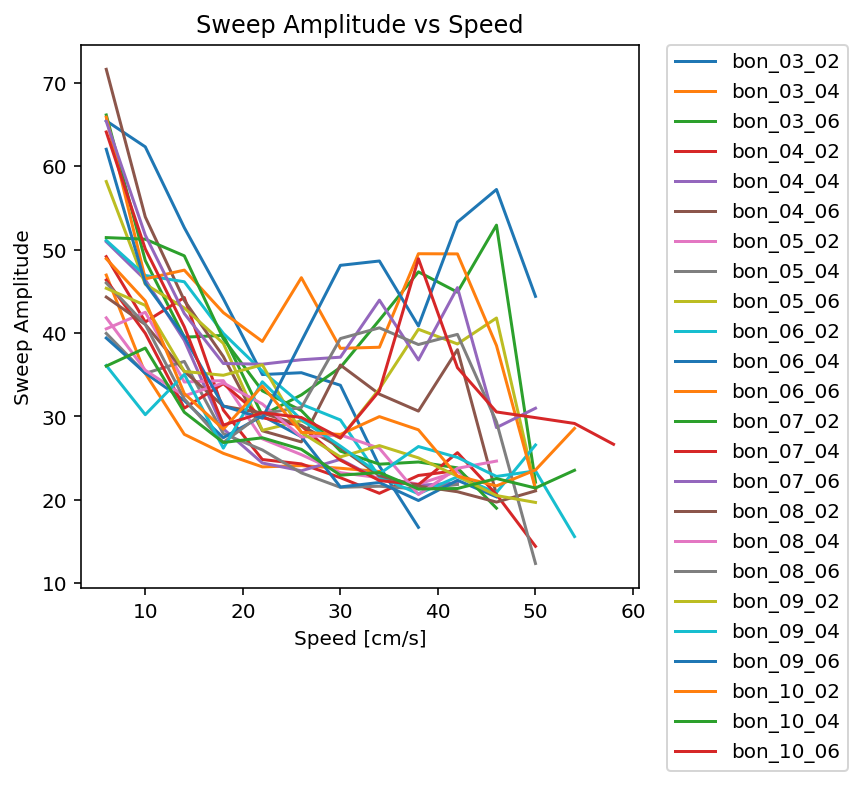

: 

In [30]:
# plot All_Speed vs All_Amp using for loop
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

for speed, amp, label in zip(All_Speed, All_Amp, All_Label):
    ax.plot(speed, amp, label=label)


ax.set_xlabel("Speed [cm/s]")
ax.set_ylabel("Sweep Amplitude")
ax.set_title("Sweep Amplitude vs Speed")
# put label out of the plot
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)

## get sweep amp against speed for animal fra

In [91]:
from loren_frank_data_processing import make_epochs_dataframe, make_neuron_dataframe
from src.parameters import ANIMALS, MAX_N_EXPOSURES, MIN_N_NEURONS
from tqdm.auto import tqdm

epoch_info = make_epochs_dataframe(ANIMALS)
neuron_info = make_neuron_dataframe(ANIMALS)
n_neurons = (
    neuron_info.groupby(["animal", "day", "epoch"])
    .neuron_id.agg(len)
    .rename("n_neurons")
    .to_frame()
)

epoch_info = epoch_info.join(n_neurons)
is_w_track = epoch_info.environment.isin(["TrackA", "TrackB", "WTrackA", "WTrackB"])

In [102]:
#extract fra, day 3 epoch 4
neuron_info.loc[('fra', 3, 4)]

area  deadchans  fs hemisphere  meanrate  \
tetrode_number neuron_number                                            
1              1              CA2        NaN NaN      right  0.602273   
               2              CA2        NaN NaN      right  1.554752   
2              1              CA2        NaN NaN      right  0.041322   
               2              CA2        NaN NaN      right  0.000000   
4              1              CA3        NaN NaN      right  1.174587   
               2              CA3        NaN NaN      right  1.017562   
               3              CA3        NaN NaN      right  0.010331   
5              1              CA3        NaN NaN      right  0.098140   
               2              CA3        NaN NaN      right  0.037190   
27             1              CA1        NaN NaN      right  0.080579   
               2              CA1        NaN NaN      right  0.001033   
               3              CA1        NaN NaN      right  1.270661   
28             1              CA3        NaN NaN      right  0.011364   
               2              CA3        NaN NaN      right  0.000000   
               3              CA3        NaN NaN      right  0.028926   
               4              CA3        NaN NaN      right  1.361570   
29             1              CA3        NaN NaN      right  0.084711   
               2              CA3        NaN NaN      right  0.000000   
               3              CA3        NaN NaN      right  0.001033   

                              nearCA2          neuron_id  numspikes  peakrate  \
tetrode_number neuron_number                                                    
1              1                  1.0  fra_03_04_001_001      583.0       NaN   
               2                  1.0  fra_03_04_001_002     1505.0       NaN   
2              1                  1.0  fra_03_04_002_001       40.0       NaN   
               2                  1.0  fra_03_04_002_002        0.0       NaN   
4              1                  0.0  fra_03_04_004_001     1137.0       NaN   
               2                  0.0  fra_03_04_004_002      985.0       NaN   
               3                  0.0  fra_03_04_004_003       10.0       NaN   
5              1                  0.0  fra_03_04_005_001       95.0       NaN   
               2                  0.0  fra_03_04_005_002       36.0       NaN   
27             1                  1.0  fra_03_04_027_001       78.0       NaN   
               2                  1.0  fra_03_04_027_002        1.0       NaN   
               3                  1.0  fra_03_04_027_003     1230.0       NaN   
28             1                  0.0  fra_03_04_028_001       11.0       NaN   
               2                  0.0  fra_03_04_028_002        0.0       NaN   
               3                  0.0  fra_03_04_028_003       28.0       NaN   
               4                  0.0  fra_03_04_028_004     1318.0       NaN   
29             1                  0.0  fra_03_04_029_001       82.0       NaN   
               2                  0.0  fra_03_04_029_002        0.0       NaN   
               3                  0.0  fra_03_04_029_003        1.0       NaN   

                              spikewidth   subarea suparea  tetnum       type  
tetrode_number neuron_number                                                   
1              1                8.816225       CA2     NaN     NaN  principal  
               2                7.435532       CA2     NaN     NaN  principal  
2              1               12.141714  CA2-CA3a     NaN     NaN  principal  
               2                     NaN  CA2-CA3a     NaN     NaN    unknown  
4              1                8.864765      CA3b     NaN     NaN  principal  
               2                8.442583      CA3b     NaN     NaN  principal  
               3                7.740862      CA3b     NaN     NaN    unknown  
5              1               10.185378      CA3b     NaN     NaN    unk

: 

In [2]:
is_animal = epoch_info.index.isin(["fra"], level="animal")

valid_epochs = (
    is_w_track
    & (epoch_info.n_neurons > MIN_N_NEURONS)
    & (epoch_info.exposure <= MAX_N_EXPOSURES)
    & is_animal
)

In [42]:
DATA_DIR = "/home/zilong/Desktop/replay_trajectory_paper/Processed-Data"

All_Speed = []
All_Amp = []
All_Label = []

for epoch_key in tqdm(epoch_info[valid_epochs].index, desc="epochs"):
    animal, day, epoch = epoch_key
    print(f"Animal: {animal}, Day: {day}, Epoch: {epoch}")

    if day > 7:
        continue

    cv_classifier_clusterless_results = xr.open_dataset(
        os.path.join(
            DATA_DIR,
            "ThetaSweepTrajectories",
            f"{animal}_{day:02d}_{epoch:02d}_cv_classifier_clusterless_results.nc",
        )
    )
    
    posterior = cv_classifier_clusterless_results.acausal_posterior

    #if if there is nan in the posterior, if yes, print "there is nan!"
    if np.isnan(posterior).any():
        print("there is nan!")
    
    with open(
        os.path.join(
            DATA_DIR,
            "ThetaSweepTrajectories",
            f"{animal}_{day:02d}_{epoch:02d}_speed_info.pkl",
        ),
        "rb",
    ) as f:
        speed = pickle.load(f)
    
    speed = speed.values

    speed_bound = np.arange(4, 64, 4)
    sweep_amps = []
    means = []

    for s in speed_bound:
        is_running = (speed > s) & (speed < s + 4)

        if sum(is_running) == 0:
            continue

        sweeps_dist_in_running = (
            cv_classifier_clusterless_results.mental_distance_from_actual_position[
                is_running
            ]
        )

        means.append(s + 2)
        sweep_amps.append(np.mean(sweeps_dist_in_running))

    All_Speed.append(means)
    All_Amp.append(sweep_amps)
    All_Label.append(f"{animal}_{day:02d}_{epoch:02d}")

epochs:   0%|          | 0/33 [00:00<?, ?it/s]

Animal: fra, Day: 2, Epoch: 2
there is nan!
Animal: fra, Day: 2, Epoch: 4
there is nan!
Animal: fra, Day: 2, Epoch: 6
there is nan!
Animal: fra, Day: 3, Epoch: 2
there is nan!
Animal: fra, Day: 3, Epoch: 4
there is nan!
Animal: fra, Day: 3, Epoch: 6
there is nan!
Animal: fra, Day: 4, Epoch: 2
there is nan!
Animal: fra, Day: 4, Epoch: 4
there is nan!
Animal: fra, Day: 4, Epoch: 6
there is nan!
Animal: fra, Day: 5, Epoch: 2
there is nan!
Animal: fra, Day: 5, Epoch: 4
there is nan!
Animal: fra, Day: 5, Epoch: 6
there is nan!
Animal: fra, Day: 6, Epoch: 2
there is nan!
Animal: fra, Day: 6, Epoch: 4
there is nan!
Animal: fra, Day: 6, Epoch: 6
there is nan!
Animal: fra, Day: 7, Epoch: 2
there is nan!
Animal: fra, Day: 7, Epoch: 4
there is nan!
Animal: fra, Day: 7, Epoch: 6
there is nan!
Animal: fra, Day: 8, Epoch: 2
Animal: fra, Day: 8, Epoch: 4
Animal: fra, Day: 8, Epoch: 6
Animal: fra, Day: 9, Epoch: 2
Animal: fra, Day: 9, Epoch: 4
Animal: fra, Day: 9, Epoch: 6
Animal: fra, Day: 10, Epoch:

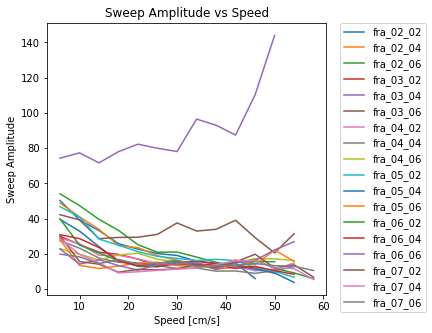

In [43]:
# plot All_Speed vs All_Amp using for loop
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

for speed, amp, label in zip(All_Speed, All_Amp, All_Label):
    ax.plot(speed, amp, label=label)


ax.set_xlabel("Speed [cm/s]")
ax.set_ylabel("Sweep Amplitude")
ax.set_title("Sweep Amplitude vs Speed")
# put label out of the plot
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)

In [32]:
for epoch_key in tqdm(epoch_info[valid_epochs].index, desc="epochs"):
    animal, day, epoch = epoch_key
    print(f"Animal: {animal}, Day: {day}, Epoch: {epoch}")

    if day > 7:
        continue

    cv_classifier_clusterless_results = xr.open_dataset(
        os.path.join(
            DATA_DIR,
            "ThetaSweepTrajectories",
            f"{animal}_{day:02d}_{epoch:02d}_cv_classifier_clusterless_results.nc",
        )
    )
    
    posterior = cv_classifier_clusterless_results.acausal_posterior.sum("state", skipna=False)

    #if if there is nan in the posterior, if yes, print "there is nan!"
    if np.isnan(posterior).any():
        print("there is nan!")
        #print the ratio of nan
        print(np.sum(np.isnan(posterior))/posterior.size)

epochs:   0%|          | 0/33 [00:00<?, ?it/s]

Animal: fra, Day: 2, Epoch: 2
there is nan!
<xarray.DataArray 'acausal_posterior' ()>
array(0.03225806)
Animal: fra, Day: 2, Epoch: 4
there is nan!
<xarray.DataArray 'acausal_posterior' ()>
array(0.03125)
Animal: fra, Day: 2, Epoch: 6
there is nan!
<xarray.DataArray 'acausal_posterior' ()>
array(0.03076923)
Animal: fra, Day: 3, Epoch: 2
there is nan!
<xarray.DataArray 'acausal_posterior' ()>
array(0.03225806)
Animal: fra, Day: 3, Epoch: 4
there is nan!
<xarray.DataArray 'acausal_posterior' ()>
array(1.)
Animal: fra, Day: 3, Epoch: 6
there is nan!
<xarray.DataArray 'acausal_posterior' ()>
array(0.22499958)
Animal: fra, Day: 4, Epoch: 2
there is nan!
<xarray.DataArray 'acausal_posterior' ()>
array(0.03174603)
Animal: fra, Day: 4, Epoch: 4
there is nan!
<xarray.DataArray 'acausal_posterior' ()>
array(0.03278689)
Animal: fra, Day: 4, Epoch: 6
there is nan!
<xarray.DataArray 'acausal_posterior' ()>
array(0.03076923)
Animal: fra, Day: 5, Epoch: 2
there is nan!
<xarray.DataArray 'acausal_post

In [28]:
posterior

<xarray.DataArray 'acausal_posterior' (time: 461490, position: 65)>
array([[0.06079323, 0.05825874, 0.05253104, ..., 0.02056385, 0.02061188,
        0.02057745],
       [0.10471573, 0.09957038, 0.08786934, ..., 0.02311327, 0.02321325,
        0.02317007],
       [0.11081245, 0.10514588, 0.09197748, ..., 0.02332907, 0.02338093,
        0.02330078],
       ...,
       [0.01536545, 0.01466533, 0.01425139, ..., 0.02144456, 0.01908533,
        0.01733684],
       [0.01525136, 0.01512928, 0.01528712, ..., 0.02170166, 0.01975419,
        0.01850132],
       [0.01525048, 0.0153874 , 0.01577255, ..., 0.02173209, 0.02013809,
        0.01915779]])
Coordinates:
  * time      (time) float64 4.722e+03 4.722e+03 ... 5.645e+03 5.645e+03
  * position  (position) float64 2.457 7.372 12.29 17.2 ... 319.2 324.1 329.0